## Imports & Helpers

In [97]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MODIFYING EARLIER TIL CUTOFFS


In [98]:
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from itertools import combinations, product

from scipy.stats import mannwhitneyu, fisher_exact, ttest_ind
from lifelines.statistics import pairwise_logrank_test, multivariate_logrank_test, survival_difference_at_fixed_point_in_time_test
from lifelines.statistics import _chisq_test_p_value

In [99]:
def filter_indices(label, index_values):
    return list(filter(lambda x: (label in x[0]) & (label in x[1]), index_values))


def chain_filter_indices(labels, index_values):
    filtered = filter_indices(labels[0], index_values)
    
    for label in labels[1:]:
        filtered = filter_indices(label, filtered)
    return filtered


def test_two_cph(alt_model, null_model):
    ll_null = null_model.log_likelihood_
    ll_alt = alt_model.log_likelihood_

    test_stat = 2 * ll_alt - 2 * ll_null
    print(test_stat)
    degrees_freedom = alt_model.params_.shape[0]
    p_value = _chisq_test_p_value(test_stat, degrees_freedom=degrees_freedom)
    
    return p_value

### Load saved files 

In [100]:
# feature_subset = pd.read_csv('./rerun_final_patient_features.csv', index_col=0)
feature_subset = pd.read_csv('./rerun_final_patient_features_RICKETTS_FILTER.csv', index_col=0)

anno = pd.read_csv('manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

node_descriptions = pd.read_csv('./rerun_node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('./rerun_proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('./rerun_slidewise_grade_til_scores.csv', index_col=0)

load_tile_info = False

if load_tile_info:
    tilewise_anno = pd.read_csv('./rerun_tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

    edge_info = pd.read_csv('./rerun_base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
    # restore set objects (stored as string when saved to csv earlier)
    edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

    # read in non-TIL tilewise info 
    seg_agg = pd.read_csv('./rerun_tilewise_grade_nontil_annotations.csv', index_col=0)
    
    edge_agg_pivot = pd.read_csv('./rerun_base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
    edge_class_sum = pd.read_csv('./rerun_base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
    edge_binary = edge_class_sum > 0

#### Prepare datasets

In [101]:
# compatibility addition
feature_subset['candidate_category'] = (feature_subset['tumor_tile_count'] >= 200).map({False:'other',True:'passing'})

In [102]:
%%capture
kirc_data = prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=True, mandatory_vars=[])
profile_data = prepare_generic_subset(feature_subset, 'profile', relabel_edge_cats=True, mandatory_vars=[])
checkmate_data = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

filtered_agg_data = pd.concat([kirc_data, profile_data, checkmate_data])

### Override previous infiltration cutoffs to simply be based on median 

In [103]:
prev = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [104]:
prev['all_nodes_area_weighted'].dropna().median()

0.1585503963759909

In [105]:
prev.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,176.0,0.370849,0.247098,0.057034,0.157776,0.337544,0.543110,0.969733
low_hg_global_infiltration,87.0,0.017764,0.016090,0.000000,0.004593,0.013818,0.030297,0.055446
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
MEDIAN_HG_INF_CUTOFF = 0.15855
print(f'Setting Area Infiltration Cutoff to be {MEDIAN_HG_INF_CUTOFF} based on Median')

Setting Area Infiltration Cutoff to be 0.15855 based on Median


In [107]:
crit = (feature_subset['cohort'] == 'cm025') & (feature_subset['usable_til_data']) & (feature_subset['all_nodes_area_weighted'] < MEDIAN_HG_INF_CUTOFF)

In [108]:
feature_subset.loc[crit, 'global_infiltration_bin'] = 'low_hg_global_infiltration'

In [109]:
update = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [110]:
update.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,132.0,0.459134,0.223431,0.15855,0.248671,0.400099,0.619838,0.969733
low_hg_global_infiltration,131.0,0.047398,0.046386,0.00000,0.008805,0.030429,0.087560,0.155452
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

In [111]:
len(kirc_data)

421

In [112]:
len(checkmate_data)

439

In [113]:
len(profile_data)

208

In [114]:
len(kirc_data)+len(checkmate_data)+len(profile_data)

1068

### Aggregate scattered specific test results 

In [115]:
scattered_results = {}

In [116]:
scattered_results['total_pancohort_patients'] = len(kirc_data)+len(checkmate_data)+len(profile_data)

### Grabbing from fragments in `main_paper_figures` NB

In [117]:
# do_rerun = False # already generated sweep results to csv
do_rerun = True # do rerun of sweep

## KIRC Sweep 
---

In [118]:
%%capture
qbins = 3
if do_rerun:
    summaries = {}
    multivar_summaries = {}
    for col_a in ['dummy_a','any_diff_edge','any_proximal_edge','any_distal_edge']:
        for col_b in ['dummy_b','grade','grade_collapsed', 'subgroup_qbin','quantile_bin','quantile_bin_collapsed']:
            for duration_var in ['os','pfs']:
                print(col_a, col_b, duration_var)

                temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
                temp['dummy_a'] = ''
                temp['dummy_b'] = ''

                if col_b == 'quantile_bin':
                    temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

                if col_b == 'grade':
                    temp = temp.loc[temp['grade'] != 'GX']

                if col_b == 'subgroup_qbin':
                    ### assign relative binary quantile bins per presence of heterogeneity [`any_diff_edge`]
                    subgroupqbins = temp.groupby(['any_diff_edge']).apply(lambda x: get_qbins_simple(x, 'nonstroma_grade_mean', 2))
                    subgroupqbins = pd.concat([x[0] for x in subgroupqbins.to_dict().values()])
                    temp['subgroup_qbin'] = subgroupqbins
                    temp['subgroup_qbin'] = temp['subgroup_qbin'].map({0:'Lower (Relative)', 1:'Higher (Relative)'})

                if col_b == 'quantile_bin_collapsed':
                    temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
                    temp['quantile_bin_collapsed'] = (temp['quantile_bin'] == 'Higher Grade').map({False:'Lower 2/3',True:'Upper Tercile'})

                temp['grade_collapsed'] = (temp['grade'] == 'G4').map({False:'G2/3',True:'G4'})
                temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})

                event_var = f'{duration_var}_event'
                df = temp.copy()
                summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b].astype(str), df[event_var]).summary     
                summary['duration'] = duration_var
                summary['col_a'] = col_a
                summary['col_b'] = col_b
                summary['test_type'] = 'pairwise_logrank'
                meta_label = f'{col_a}_{col_b}_{duration_var}'
                summary['meta'] = meta_label
                summaries[meta_label] = summary.copy()

                df = temp.copy()
                summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b].astype(str), df[event_var]).summary
                summary['duration'] = duration_var
                summary['col_a'] = col_a
                summary['col_b'] = col_b
                summary['test_type'] = 'multivariate_logrank'
                meta_label = f'{col_a}_{col_b}_{duration_var}'
                summary['meta'] = meta_label
                multivar_summaries[meta_label] = summary.copy()


    # summaries = pd.concat(summaries.values())
    # pd.concat(summaries.values()).to_csv(f'[rerun] KIRC sweep [Pairwise logrank].csv')
    pd.concat([x for x in summaries.values() if len(x.index.values) > 0]).to_csv(f'[rerun] KIRC sweep [Pairwise logrank].csv')


    # multivar_summaries = pd.concat(multivar_summaries.values())
    pd.concat(multivar_summaries.values()).to_csv(f'[rerun] KIRC sweep [Multivariate logrank].csv')

## CM025 Sweeps
---

### CM025: Edge binary status, all splits

In [119]:
if do_rerun:
    temp = checkmate_data.copy()
    temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})
    temp['any_hg_diff_edge'] = temp['any_hg_diff_edge'].map({'no_high_grade_diff_edge':'Homogeneous','high_grade_diff_edge':'Heterogeneous'})
    temp['quantile_bin'] = temp['quantile_bin'].astype(str)
    summaries = {}
    for col_a in ['any_diff_edge','quantile_bin']: # omitting proximal and distal specific reruns
        for duration_var in ['os','pfs']:
            event_var = f'{duration_var}_event'
            for drug_type in ['ICI','Non-ICI']:
                df = temp.loc[temp['drug_type'] == drug_type]
                summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a], df[event_var]).summary
                summary['duration'] = duration_var
                summary['drug_type'] = drug_type
                summary['col_a'] = col_a
                summary['meta'] = f'{col_a}_{drug_type}_{duration_var}'
                summaries[f'{col_a}_{drug_type}_{duration_var}'] = summary
        #         summary.print_summary()
    summaries = pd.concat(summaries.values())

    summaries.to_csv('./[rerun] CM025 - Edge binary status, all splits [Pairwise logrank].csv')

### CM025: Edge binary status x QBIN, all splits [Pairwise logrank & Multivariate logrank]

In [120]:
%%capture
qbins = 2
mandatory_vars = []
if do_rerun:
    for drop_intermediate in [False]:
        summaries = {}
        multivar_summaries = {}
        for col_a in ['any_diff_edge','any_proximal_edge','any_distal_edge']:
            for col_b in ['subgroup_qbin','quantile_bin']:
                for duration_var in ['os','pfs']:
                    print(col_a, col_b, duration_var)
                    temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', til_only_cases=False, high_grade_filter=False,
                                    drop_intermed_group=drop_intermediate, qbins=qbins, mandatory_vars=mandatory_vars)

                    temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})
                    temp['any_hg_diff_edge'] = temp['any_hg_diff_edge'].map({'no_high_grade_diff_edge':'Homogeneous','high_grade_diff_edge':'Heterogeneous'})

                    ### assign relative quantile bins per presence of heterogeneity [`any_diff_edge`]
                    subgroupqbins = temp.groupby(['any_diff_edge']).apply(lambda x: get_qbins_simple(x, 'nonstroma_grade_mean', qbins))

                    subgroupqbins = pd.concat([x[0] for x in subgroupqbins.to_dict().values()])

                    temp['subgroup_qbin'] = subgroupqbins
                    temp['subgroup_qbin'] = temp['subgroup_qbin'].map({0:'Lower (Relative)', 1:'Higher (Relative)'})

                    event_var = f'{duration_var}_event'
                    for drug_type in ['ICI','Non-ICI']:
                        df = temp.loc[temp['drug_type'] == drug_type]
                        summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b].astype(str), df[event_var]).summary
                        summary['duration'] = duration_var
                        summary['drug_type'] = drug_type
                        summary['col_a'] = col_a
                        summary['col_b'] = col_b
                        summary['test_type'] = 'pairwise_logrank'
                        summary['dropped_intermediate'] = drop_intermediate
                        meta_label = f'{col_a}_{col_b}_{drug_type}_{duration_var}'
                        summary['meta'] = meta_label
                        summaries[meta_label] = summary

                        summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b].astype(str), df[event_var]).summary
                        summary['duration'] = duration_var
                        summary['drug_type'] = drug_type
                        summary['col_a'] = col_a
                        summary['col_b'] = col_b
                        summary['test_type'] = 'multivariate_logrank'
                        summary['dropped_intermediate'] = drop_intermediate
                        meta_label = f'{col_a}_{col_b}_{drug_type}_{duration_var}'
                        summary['meta'] = meta_label
                        multivar_summaries[meta_label] = summary


        summaries = pd.concat(summaries.values())
        drop_flag = 'dropped_intermediate_benefit' if drop_intermediate else 'including_intermediate_benefit'
        summaries.to_csv(f'[rerun] CM025 - Edge binary status x QBIN, all splits {drop_flag} [Pairwise logrank].csv')

        multivar_summaries = pd.concat(multivar_summaries.values())
        drop_flag = 'dropped_intermediate_benefit' if drop_intermediate else 'including_intermediate_benefit'
        multivar_summaries.to_csv(f'[rerun] CM025 - Edge binary status x QBIN, all splits {drop_flag} [Multivariate logrank].csv')

### CM025: Edge binary status x TIL, all splits [Pairwise logrank & Multivariate logrank]

In [121]:
%%capture
qbins = 2

mandatory_vars = []

if do_rerun:
    for drop_intermediate in [False]:
        summaries = {}
        multivar_summaries = {}
        for col_a in ['any_diff_edge', 'any_hg_diff_edge', 'is_het_hiTIL', 'is_hghet_hiTIL', 'any_proximal_edge','any_distal_edge']:
            for col_b in ['dummy','global_infiltration_bin']:
                for duration_var in ['os','pfs']:
                    temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', til_only_cases=True, high_grade_filter=True, 
                                    drop_intermed_group=drop_intermediate, qbins=qbins, mandatory_vars=mandatory_vars)

                    temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})
                    temp['any_hg_diff_edge'] = temp['any_hg_diff_edge'].map({'no_high_grade_diff_edge':'Homogeneous','high_grade_diff_edge':'Heterogeneous'})

                    temp['is_het_hiTIL'] = (temp['any_diff_edge'] == 'Heterogeneous') & (temp['global_infiltration_bin'] == 'high_hg_global_infiltration')
                    temp['is_het_hiTIL'] = temp['is_het_hiTIL'].map({False:'Rest',True:'GradeHet + High Infiltration'})

                    # high_grade_distal_edge
                    temp['is_hghet_hiTIL'] = (temp['any_hg_diff_edge'] == 'Heterogeneous') & (temp['global_infiltration_bin'] == 'high_hg_global_infiltration')
                    temp['is_hghet_hiTIL'] = temp['is_hghet_hiTIL'].map({False:'Rest',True:'HG GradeHet + High Infiltration'})

                    temp['dummy'] = ''

                    event_var = f'{duration_var}_event'
                    for drug_type in ['ICI','Non-ICI']:
                        df = temp.loc[temp['drug_type'] == drug_type]
                        summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b], df[event_var]).summary
                        summary['duration'] = duration_var
                        summary['drug_type'] = drug_type
                        summary['col_a'] = col_a
                        summary['col_b'] = col_b
                        summary['test_type'] = 'pairwise_logrank'
                        summary['dropped_intermediate'] = drop_intermediate
                        meta_label = f'{col_a}_{col_b}_{drug_type}_{duration_var}'
                        summary['meta'] = meta_label
                        summaries[meta_label] = summary

                        summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b], df[event_var]).summary
                        summary['duration'] = duration_var
                        summary['drug_type'] = drug_type
                        summary['col_a'] = col_a
                        summary['col_b'] = col_b
                        summary['test_type'] = 'multivariate_logrank'
                        summary['dropped_intermediate'] = drop_intermediate
                        meta_label = f'{col_a}_{col_b}_{drug_type}_{duration_var}'
                        summary['meta'] = meta_label
                        multivar_summaries[meta_label] = summary


        summaries = pd.concat(summaries.values())
        drop_flag = 'dropped_intermediate_benefit' if drop_intermediate else 'including_intermediate_benefit'
        summaries.to_csv(f'[rerun] CM025 - Edge binary status + TIL binary status, all splits {drop_flag} [Pairwise logrank].csv')

        multivar_summaries = pd.concat(multivar_summaries.values())
        drop_flag = 'dropped_intermediate_benefit' if drop_intermediate else 'including_intermediate_benefit'
        multivar_summaries.to_csv(f'[rerun] CM025 - Edge binary status + TIL binary status, all splits {drop_flag} [Multivariate logrank].csv')

In [122]:
temp

,tile_count,cohort,tumor_tile_fraction,tumor_tile_count,pfs,pfs_event,os,os_event,ttf,ttf_event,...,proximal_edge_detailed,candidate_category,tcga_ricketts_grade,quantile_bin,MSKCC,recist_is_crpr_not_pd,benefit_is_cb_not_ncb,is_het_hiTIL,is_hghet_hiTIL,dummy
unique_id,,,,,,,,,,,,,,,,,,,,,
cm025_1007,3678,cm025,0.525014,1931,1.905544,1.0,4.336756,1.0,1.905544,1.0,...,no_high_grade_proximal_edge,passing,NaN,quantile_bin_1,INTERMEDIATE,False,False,Rest,Rest,
cm025_101,4449,cm025,0.731625,3255,1.905544,1.0,4.533881,1.0,1.905544,1.0,...,no_high_grade_proximal_edge,passing,NaN,quantile_bin_1,INTERMEDIATE,False,False,Rest,Rest,
cm025_1027,3431,cm025,0.395512,1357,2.398357,1.0,34.266940,0.0,2.398357,1.0,...,no_high_grade_proximal_edge,passing,NaN,quantile_bin_0,FAVORABLE,False,False,Rest,Rest,
cm025_1031,4721,cm025,0.612582,2892,1.806982,1.0,2.201232,1.0,1.806982,1.0,...,no_high_grade_proximal_edge,passing,NaN,quantile_bin_1,POOR,False,False,Rest,Rest,
cm025_1034,7107,cm025,0.836359,5944,1.741273,1.0,10.151951,1.0,1.741273,1.0,...,no_high_grade_proximal_edge,passing,NaN,quantile_bin_0,FAVORABLE,False,False,GradeHet + High Infiltration,Rest,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cm025_972,3968,cm025,0.490675,1947,1.675565,1.0,14.685832,1.0,1.675565,1.0,...,high_grade_proximal_edge,passing,NaN,quantile_bin_0,INTERMEDIATE,False,False,Rest,Rest,
cm025_99,5243,cm025,0.524318,2749,46.225873,1.0,63.211499,0.0,46.225873,1.0,...,high_grade_proximal_edge,passing,NaN,quantile_bin_0,FAVORABLE,True,True,Rest,Rest,
cm025_995,5770,cm025,0.430676,2485,5.519507,1.0,19.679671,1.0,5.519507,1.0,...,no_high_grade_proximal_edge,passing,NaN,quantile_bin_1,INTERMEDIATE,False,False,Rest,Rest,


---

---

---

## Non-sweep test result aggregation
---

### Edge vs Driver Plots [Count]

In [123]:
def get_labels_string(annotation, sep=' vs. '):
    labels_string = sep.join([struct["label"]
                          for struct in annotation.structs])    
    return labels_string

def retrieve_label_and_pval_from_annotation(annotation):
    label = get_labels_string(annotation)
    pval = annotation.data.pvalue
    
    return label, pval

def unpack_annotator(annotator):
    results = {}
    for annotation in annotator.annotations:
        label = get_labels_string(annotation)
        pval = annotation.data.pvalue
        results[label] = pval
    return results

In [124]:
%%capture
col_rename = {
    'all_rag_edge_total':'Proximal + Distal Edge Count',
    'edge_class_proximal':'Proximal Edge Count',
    'edge_class_distal':'Distal Edge Count',
}

set_rc(8,8, 2)
gene = 'PBRM1'
df = filtered_agg_data.loc[filtered_agg_data[gene] != 'no_info']
df['Cohort'] = df['cohort'].str.upper()

x = 'Cohort'
for gene in ['PBRM1','BAP1','SETD2']:
    for y in ['all_rag_edge_total','edge_class_proximal','edge_class_distal']:
        print(f'===== {y} =====')
        order = [x.upper() for x in ['cm025','kirc','profile']]
        hue = gene
        hue_order = ['WT','MUT']

        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)

        # pairs = list(combinations(product(df[x].unique(), df[hue].unique()), 2))
        pairs = [list(product([cohort], df[hue].unique())) for cohort in df[x].unique()]

        annotator = Annotator(g, pairs, order=order, data=df, x=x, y=y, hue=hue, hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', text_format='star')
        annotator.apply_and_annotate()
        plt.ylim(0,2.5)
        plt.title(col_rename[y])
        plt.ylabel('Count')
        plt.show()
    
        out = unpack_annotator(annotator)
        pval_str_mapper = {f'[fig3a] [mwu] {gene} + {y}: {k}':v for k,v in out.items()}
        scattered_results.update(pval_str_mapper)
    
#         pair_str_names = [' vs '.join(['_'.join(y) for y in x]) for x in pairs]
#         pair_str_names = [f'[fig3] [mwu] {gene} + {y}: {x}' for x in pair_str_names]
#         pval_str_mapper = {k:v.formatted_output for k,v in zip(pair_str_names, annotator.annotations)}
#         scattered_results.update(pval_str_mapper)

### Edge vs Driver Plots [Frequency]

In [125]:
%%capture
set_rc(8,8,2)
gene = 'PBRM1'

qbins = 2

mandatory_vars = []
kirc_data = prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=False, qbins=qbins)
profile_data = prepare_generic_subset(feature_subset, 'profile', relabel_edge_cats=False, qbins=qbins)
checkmate_data = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=False, qbins=qbins, mandatory_vars=mandatory_vars)

filtered_agg_data = pd.concat([kirc_data, profile_data, checkmate_data])

df = filtered_agg_data.loc[filtered_agg_data[gene] != 'no_info']
df = df.loc[df['cohort'] != 'profile']
df['Cohort'] = df['cohort'].str.upper()

x = 'Cohort'
y = 'any_diff_edge'

freq_map = {
    'any_diff_edge':'Proximal or Distal',
    'any_proximal_edge':'Proximal Only',
    'any_distal_edge':'Distal Only'
}

for gene in ['PBRM1','BAP1','SETD2']:
    for y in ['any_diff_edge','any_proximal_edge','any_distal_edge']:
        order = [x.upper() for x in ['cm025','kirc']]
        hue = gene
        hue_order = ['WT','MUT']

        conting_upstream = df.set_index([x,hue])[y].reset_index().value_counts([x,hue,y],sort=False)
        manual_fisher_pvals = {cohort:fisher_exact(conting_upstream.loc[cohort].values.reshape((2,2)))[1] for cohort in order}


        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)
        g.legend(title=gene,loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

        pairs = [list(product([cohort], df[hue].unique())) for cohort in order]
        pvals = [manual_fisher_pvals[x[0][0]] for x in pairs]

        pair_str_names = [' vs '.join(['_'.join(y) for y in x]) for x in pairs]
        pair_str_names = [f'[fig3a] [fisher] {gene} + {y}: {x}' for x in pair_str_names]
        pval_str_mapper = {k:v for k,v in zip(pair_str_names, pvals)}
        scattered_results.update(pval_str_mapper)

### 3b: 9p21.3 

In [126]:
set_rc(8,8, 1.5)

In [127]:
kirc_9p = pd.read_csv('/home/jupyter/checkmate-histo/consolidated_workflow/kirc_gistic_9p213_labeled.csv',index_col=0)

anno['9p21.3'] = anno['Deletion_9p21.3'].map({'MUT':'LOSS','WT':'WT'})

### 9p21.3 vs edge

In [128]:
%%capture
qbins = 2
mandatory_vars = []
kirc_data = prepare_generic_subset(feature_subset, 'kirc', relabel_edge_cats=False, qbins=qbins)
profile_data = prepare_generic_subset(feature_subset, 'profile', relabel_edge_cats=False, qbins=qbins)
checkmate_data = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=False, qbins=qbins, mandatory_vars=mandatory_vars)

filtered_agg_data = pd.concat([kirc_data, profile_data, checkmate_data])
filtered_agg_data = filtered_agg_data.join(pd.concat([anno[['9p21.3']], kirc_9p]))

df = filtered_agg_data.loc[filtered_agg_data['9p21.3'].isin(['WT','LOSS'])]
print('only grabbing Stage IV KIRC + above median GS')
df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['stage'] == 'Stage IV') & (df['quantile_bin'] == 'quantile_bin_1'))]

# df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['quantile_bin'] == 'quantile_bin_1'))]

# df = df.loc[(df['cohort'] == 'cm025') | ((df['cohort'] == 'kirc') & (df['stage'] == 'Stage IV'))]

df['Cohort'] = df['cohort'].str.upper()
df['Cohort'] = df['Cohort'].replace({'KIRC':'TCGA-KIRC','CM025':'CM-025', 'PROFILE':'DFCI-PROFILE'})
df['9p21.3_ind'] = df['9p21.3'] == 'LOSS'

x = 'Cohort'
y = 'any_diff_edge'

freq_map = {
    'any_diff_edge':'Proximal or Distal',
    'any_proximal_edge':'Proximal Only',
    'any_distal_edge':'Distal Only'
}

for gene in ['9p21.3']:
    for y in ['any_diff_edge','any_proximal_edge','any_distal_edge']:
        order = [x.upper() for x in ['cm-025','tcga-kirc']]
        hue = gene
        hue_order = ['WT','LOSS']

        conting_upstream = df.set_index([x,hue])[y].reset_index().value_counts([x,hue,y],sort=False)
        manual_fisher_pvals = {cohort:fisher_exact(conting_upstream.loc[cohort].values.reshape((2,2)))[1] for cohort in order}


        df = df.dropna(subset=[x,y,hue])


        g = sns.barplot(x=x, order=order, y=y, hue=hue, data=df,
                     hue_order=hue_order,)
        g.legend(title=gene,loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

        pairs = [list(product([cohort], df[hue].unique())) for cohort in order]
        pvals = [manual_fisher_pvals[x[0][0]] for x in pairs]

        annotator = Annotator(g, pairs, data=df, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
        annotator.set_pvalues(pvals)
        annotator.annotate()
        plt.ylabel('Frequency')
        plt.title(f'Grade-Heterogeneity Frequency \n {freq_map[y]}')
        plt.ylim(0,1.1)
#         plt.savefig(f'./main_figs/{y}_frequency_vs_9p213_status__cm025_all__kirc_stage4_abovemedianGS.pdf', bbox_inches='tight')
        plt.show()
    
#         out = unpack_annotator(annotator)
#         pval_str_mapper = {f'[fig3b] [mwu] {gene} + {y}: {k}':v for k,v in out.items()}
#         scattered_results.update(pval_str_mapper)

        pair_str_names = [' vs '.join(['_'.join(y) for y in x]) for x in pairs]
        pair_str_names = [f'[fig3b] [fisher] {gene} + {y}: {x}' for x in pair_str_names]
        pval_str_mapper = {k:v for k,v in zip(pair_str_names, pvals)}
        scattered_results.update(pval_str_mapper)

### bootstrapped c-index pvals

#### MWU on actual value distributions produced

In [129]:
%%capture
comp_df = pd.read_csv('./bootstrapped_cindex_continuous_vs_categorical_grade_kirc.csv')
df = comp_df.copy()

plot_kws = {
    'order':['PFS','OS'],
    'x':'Survival Type',
    'y':'C-Index',
    'hue':'Grade Type',
    'hue_order':['Categorical','Continuous'],
    'data':df
}

set_rc(8,8, 1.5)
g = sns.boxplot(**plot_kws)
pairs = [list(product([x_val], df[plot_kws['hue']].unique())) for x_val in df[plot_kws['x']].unique()]
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

# pair_str_names = [' vs '.join(['_'.join(y) for y in x]) for x in pairs]
# pair_str_names = [f'[fig2] [mwu]: bootstrapped c-index {x}' for x in pair_str_names]
# pval_str_mapper = {k:v.formatted_output for k,v in zip(pair_str_names, annotator.annotations)}
# scattered_results.update(pval_str_mapper)

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1g] [mwu]: bootstrapped c-index {k}':v for k,v in out.items()}
scattered_results.update(pval_str_mapper)

#### chi2 comparing loglikelihoods

In [130]:
mandatory_vars = ['os','os_event','pfs','pfs_event']

In [131]:
l1_ratio = 0.
penalizer = 0.1
duration_var = 'os'
event_var = f'{duration_var}_event'

df = prepare_generic_subset(feature_subset, 'kirc', mandatory_vars=mandatory_vars)

cat_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
cat_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':'grade'})

cont_model =  CoxPHFitter()
cont_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':'nonstroma_grade_mean'})
result = test_two_cph(alt_model=cont_model, null_model=cat_model)
print(result)
scattered_results['[fig1g] [chi2 llr]: OS categorical vs continuous'] = result

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
dropping entries missing any in ['os', 'os_event', 'pfs', 'pfs_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(429, 148)
grade quantile bins:  [0.0524563  0.33959318 0.58796686 0.95407209]
(429, 149)
dropping low tumor tile count cases
(429, 149)
dropping G1 [keeping unannotated cases]
(419, 149)
dropping metastatic biopsies
(419, 149)
keeping all stages 
(419, 149)
converting bool edge presence labels to string
-7.446557603178235
1.0


In [132]:
l1_ratio = 0.
penalizer = 0.1
duration_var = 'pfs'
event_var = f'{duration_var}_event'

df = prepare_generic_subset(feature_subset, 'kirc', mandatory_vars=mandatory_vars)

cat_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
cat_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':'grade'})

cont_model =  CoxPHFitter()
cont_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':'nonstroma_grade_mean'})
result = test_two_cph(alt_model=cont_model, null_model=cat_model)
scattered_results['[fig1g] [chi2 llr]: PFS categorical vs continuous'] = result

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
dropping entries missing any in ['os', 'os_event', 'pfs', 'pfs_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(429, 148)
grade quantile bins:  [0.0524563  0.33959318 0.58796686 0.95407209]
(429, 149)
dropping low tumor tile count cases
(429, 149)
dropping G1 [keeping unannotated cases]
(419, 149)
dropping metastatic biopsies
(419, 149)
keeping all stages 
(419, 149)
converting bool edge presence labels to string
13.388133720579617


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIRC_G2 v.s. KIRC_G4: Mann-Whitney-Wilcoxon test two-sided, P_val=1.123e-19 U_stat=1.374e+03
PROFILE_G4 v.s. PROFILE_G3: Mann-Whitney-Wilcoxon test two-sided, P_val=4.098e-11 U_stat=5.379e+03
CM025_G4 v.s. CM025_G3: Mann-Whitney-Wilcoxon test two-sided, P_val=5.003e-10 U_stat=5.425e+03
CM025_G2 v.s. CM025_G4: Mann-Whitney-Wilcoxon test two-sided, P_val=2.894e-20 U_stat=3.120e+02
PROFILE_G2 v.s. PROFILE_G4: Mann-Whitney-Wilcoxon test two-sided, P_val=1.871e-21 U_stat=3.620e+02
KIRC_G4 v.s. KIRC_G3: Mann-Whitney-Wilcoxon test two-sided, P_val=3.655e-10 U_stat=8.220e+03
CM025_G2 v.s. CM025_G3: Mann-Whitney-Wilcoxon test two-sided, P_val=8.951e-09 U_stat=9.130e+02
PROFILE_G2 v.s. PROFILE_G3: Mann-Whitney-Wilcoxon test two-sided, P_val=9.525e-11 U_stat=1.887e+03
KIRC_G2 v.s. KIRC_G3: Mann-Whitney-Wilcoxon test two-sided, P_val=1.

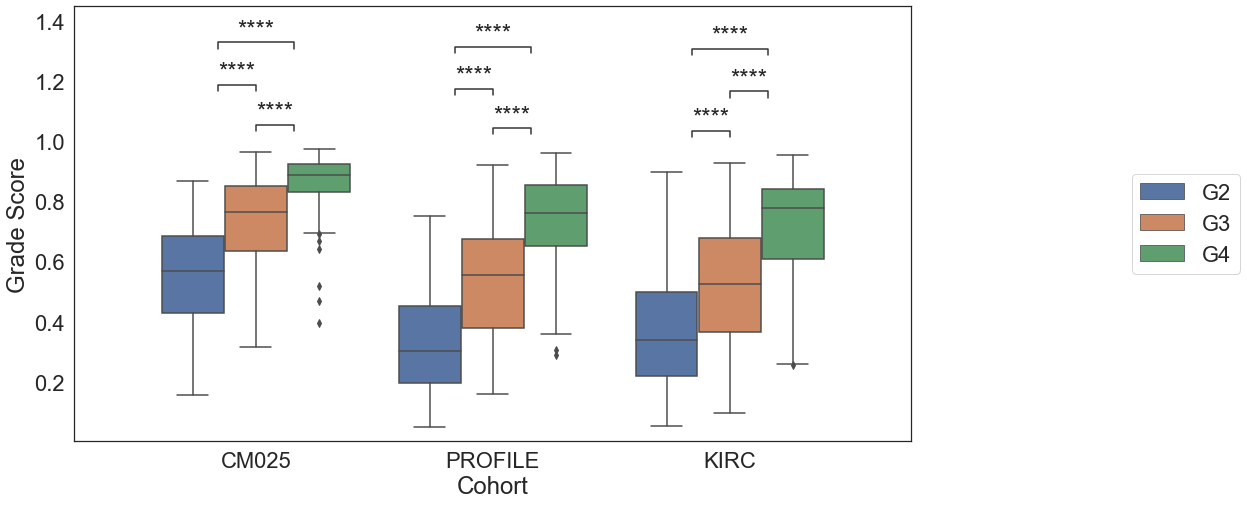

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CM025_G3 vs. CM025_G4: Mann-Whitney-Wilcoxon test two-sided, P_val:5.003e-10 U_stat=1.531e+03
PROFILE_G2 vs. PROFILE_G3: Mann-Whitney-Wilcoxon test two-sided, P_val:9.525e-11 U_stat=1.887e+03
PROFILE_G3 vs. PROFILE_G4: Mann-Whitney-Wilcoxon test two-sided, P_val:4.098e-11 U_stat=1.341e+03
KIRC_G2 vs. KIRC_G3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.671e-10 U_stat=9.613e+03
KIRC_G3 vs. KIRC_G4: Mann-Whitney-Wilcoxon test two-sided, P_val:3.655e-10 U_stat=2.490e+03
CM025_G2 vs. CM025_G3: Mann-Whitney-Wilcoxon test two-sided, P_val:8.951e-09 U_stat=9.130e+02
PROFILE_G2 vs. PROFILE_G4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.871e-21 U_stat=3.620e+02
CM025_G2 vs. CM025_G4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.894e-20 U_stat=3.120e+02
KIRC_G2 vs. KIRC_G4: Mann-Whitney-Wilcoxon test two-sided, 

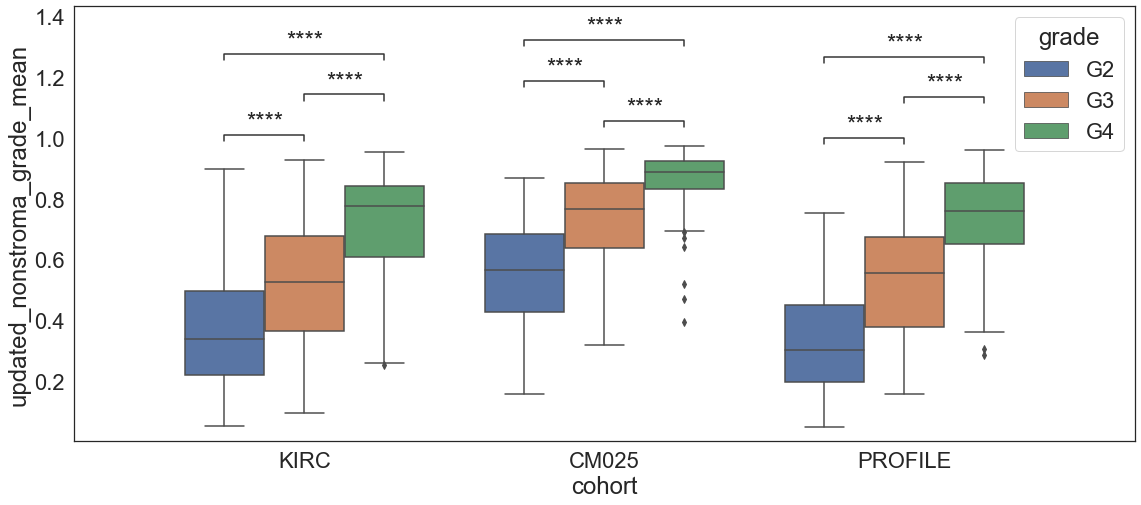

In [133]:
set_rc(15,8, 2)
sns.set_style('white')

data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()

x = 'cohort'
y = 'updated_nonstroma_grade_mean'
hue = 'grade'

hue_order = ['G2','G3','G4']
order = [x.upper() for x in ['kirc','cm025','profile']]
box_pairs = []
[box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025','PROFILE']]

# box_pairs = list(combinations(['G2','G3','G4'], 2))

g = sns.boxplot(x=x, hue=hue, hue_order=hue_order, y=y, data=data)
move_leg(g)
test_results = add_stat_annotation(g, data=data, x=x, y=y, hue=hue,
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2, comparisons_correction=None)
test_results

plt.ylabel('Grade Score')
plt.xlabel('Cohort')

plt.show()

set_rc(19,8, 2)
sns.set_style('white')
plot_kws = {
    'order':[x.upper() for x in ['kirc','cm025','profile']],
    'x':'cohort',
    'y':'updated_nonstroma_grade_mean',
    'hue':'grade',
    'hue_order':['G2','G3','G4'],
    'data':data
}

g = sns.boxplot(**plot_kws)
pairs = box_pairs
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

# pair_str_names = [' vs '.join(['_'.join(y) for y in x]) for x in pairs]
# pair_str_names = [f'[fig1] [mwu]: gradescore vs assigned {x}' for x in pair_str_names]
# pval_str_mapper = {k:v.formatted_output for k,v in zip(pair_str_names, annotator.annotations)}
# scattered_results.update(pval_str_mapper)


out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1d] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}
scattered_results.update(pval_str_mapper)

In [134]:
# sorted_keys = sorted(list(scattered_results.keys()))
# sorted_results = {k:scattered_results[k] for k in sorted_keys}

### Fig 1E/F

In [135]:
kirc_multivar_sweep = pd.read_csv('./[rerun] KIRC sweep [Multivariate logrank].csv')
kirc_pairwise_sweep = pd.read_csv('./[rerun] KIRC sweep [Pairwise logrank].csv',index_col=[0,1])
# kirc_pairwise_sweep = pd.read_csv('./[rerun] KIRC sweep [Pairwise logrank].csv',index_col=0)

In [136]:
subset = kirc_multivar_sweep.loc[(kirc_multivar_sweep['col_a'] == 'dummy_a') & (kirc_multivar_sweep['col_b'] == 'quantile_bin')]
subset
for x, row in subset.iterrows():
    dur = row['duration']
    result_key = f'[fig1f] [multivariate logrank] qbin3 {dur}: '
    result_pval = row['p']
    print(result_key, result_pval)
    scattered_results[result_key] = result_pval

[fig1f] [multivariate logrank] qbin3 os:  1.09290945014112e-06
[fig1f] [multivariate logrank] qbin3 pfs:  3.897908058694395e-15


In [137]:
for duration_var in ['os','pfs']:
    subset = kirc_pairwise_sweep.loc[(kirc_pairwise_sweep['col_a'] == 'dummy_a') & (kirc_pairwise_sweep['col_b'] == 'quantile_bin') & (kirc_pairwise_sweep['duration'] == duration_var)]
    
    for x, row in subset.iterrows():
        result_key = f'[fig1f] [pairwise logrank] qbin3 {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig1f] [pairwise logrank] qbin3 OS:  + Higher Grade vs. OS:  + Intermed. Grade 0.0083883232433765
[fig1f] [pairwise logrank] qbin3 OS:  + Higher Grade vs. OS:  + Lower Grade 1.933637354645779e-07
[fig1f] [pairwise logrank] qbin3 OS:  + Intermed. Grade vs. OS:  + Lower Grade 0.0058493410633129
[fig1f] [pairwise logrank] qbin3 PFS:  + Higher Grade vs. PFS:  + Intermed. Grade 1.111062743683745e-05
[fig1f] [pairwise logrank] qbin3 PFS:  + Higher Grade vs. PFS:  + Lower Grade 4.373827328844424e-15
[fig1f] [pairwise logrank] qbin3 PFS:  + Intermed. Grade vs. PFS:  + Lower Grade 0.0001137555361996


#### Diversion: score biasing between cohorts


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

G3_PROFILE vs. G3_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:3.652e-11 U_stat=1.446e+03
G4_KIRC vs. G4_PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:6.217e-01 U_stat=2.095e+03
G4_PROFILE vs. G4_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:2.920e-09 U_stat=1.504e+03
G2_KIRC vs. G2_PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:1.131e-01 U_stat=9.155e+03
G2_PROFILE vs. G2_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:5.426e-10 U_stat=1.025e+03
G3_KIRC vs. G3_PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:5.245e-01 U_stat=7.776e+03
G4_KIRC vs. G4_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:3.260e-09 U_stat=1.308e+03
G3_KIRC vs. G3_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.378e-13 U_stat=2.540e+03
G2_KIRC vs. G2_CM025: Mann-Whitney-Wilcoxon test two-sided, 

(<AxesSubplot:title={'center':'Assigned Grade vs Score'}, xlabel='grade', ylabel='Grade Score'>,
  <statannotations.Annotation.Annotation at 0x7f30390c4d30>])

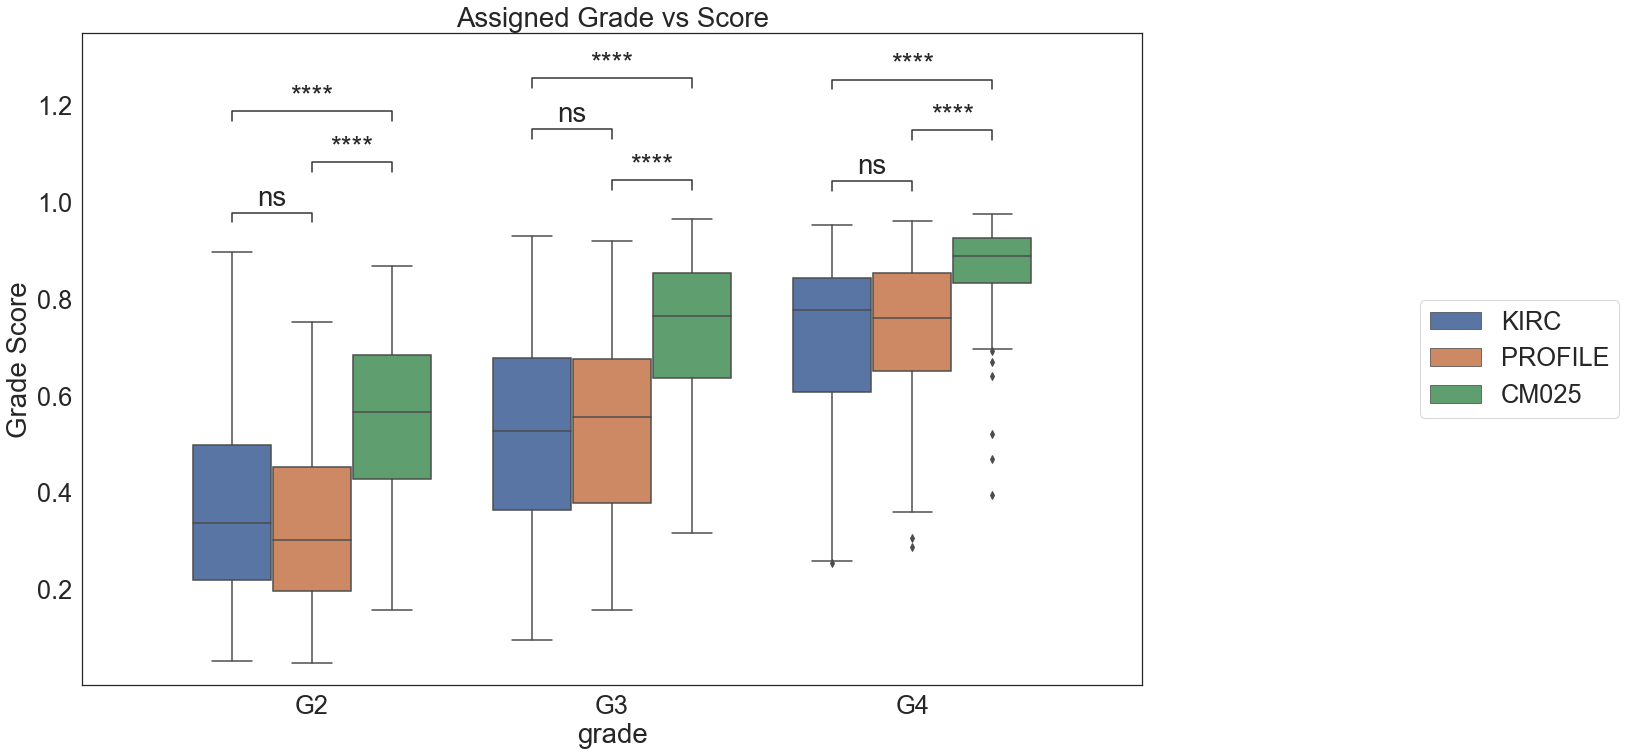

In [138]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()


box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':['G2','G3','G4'],
    'x':'grade',
    'y':'updated_nonstroma_grade_mean',
    'hue':'cohort',
    'hue_order':['KIRC','PROFILE','CM025'],
    'data':data
}

g = sns.boxplot(**plot_kws)
plt.ylabel('Grade Score')
move_leg(g)
plt.title('Assigned Grade vs Score')
pairs = box_pairs
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

# out = unpack_annotator(annotator)
# pval_str_mapper = {f'[fig1d] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

In [139]:
(data['stage'] == 'Stage IV')|( data['cohort'] == 'CM025')

unique_id
cm025_1          True
cm025_1000       True
cm025_1001       True
cm025_1002       True
cm025_1006       True
                ...  
TCGA-G6-A8L8    False
TCGA-GK-A6C7    False
TCGA-MM-A563    False
TCGA-MM-A564    False
TCGA-T7-A92I    False
Length: 1392, dtype: bool

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

G3_PROFILE vs. G3_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:3.312e-04 U_stat=4.530e+02
G4_KIRC vs. G4_PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:9.375e-01 U_stat=4.620e+02
G4_PROFILE vs. G4_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.012e-05 U_stat=8.430e+02
G2_KIRC vs. G2_PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:7.453e-02 U_stat=2.700e+01
G2_PROFILE vs. G2_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:8.792e-03 U_stat=1.000e+02
G3_KIRC vs. G3_PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:7.699e-01 U_stat=3.400e+02
G4_KIRC vs. G4_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:2.286e-04 U_stat=6.430e+02
G3_KIRC vs. G3_CM025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.549e-03 U_stat=5.860e+02
G2_KIRC vs. G2_CM025: Mann-Whitney-Wilcoxon test two-sided, 

(<AxesSubplot:title={'center':'Assigned Grade vs Score \n Stage IV only'}, xlabel='grade', ylabel='Grade Score'>,
  <statannotations.Annotation.Annotation at 0x7f3039384370>])

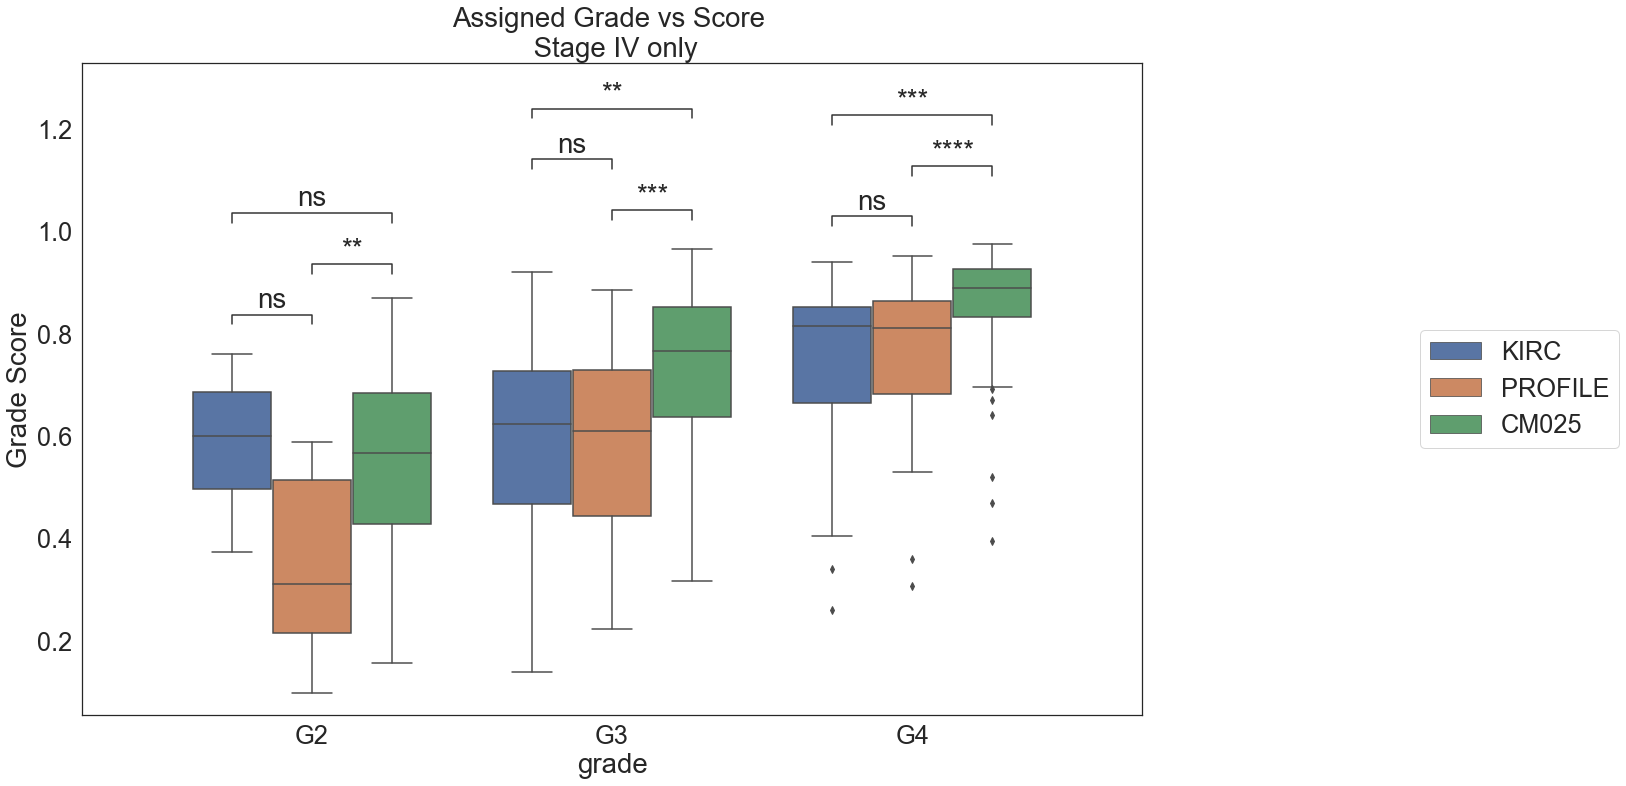

In [140]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
data = data.loc[(data['stage'] == 'Stage IV')| (data['cohort'] == 'CM025')]

box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':['G2','G3','G4'],
    'x':'grade',
    'y':'updated_nonstroma_grade_mean',
    'hue':'cohort',
    'hue_order':['KIRC','PROFILE','CM025'],
    'data':data
}

g = sns.boxplot(**plot_kws)
plt.ylabel('Grade Score')
move_leg(g)
plt.title('Assigned Grade vs Score \n Stage IV only')
pairs = box_pairs
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

# out = unpack_annotator(annotator)
# pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PROFILE vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.565e-04 U_stat=6.028e+04
CM025 vs. PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:4.565e-21 U_stat=1.307e+05
CM025 vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.818e-13 U_stat=1.817e+05


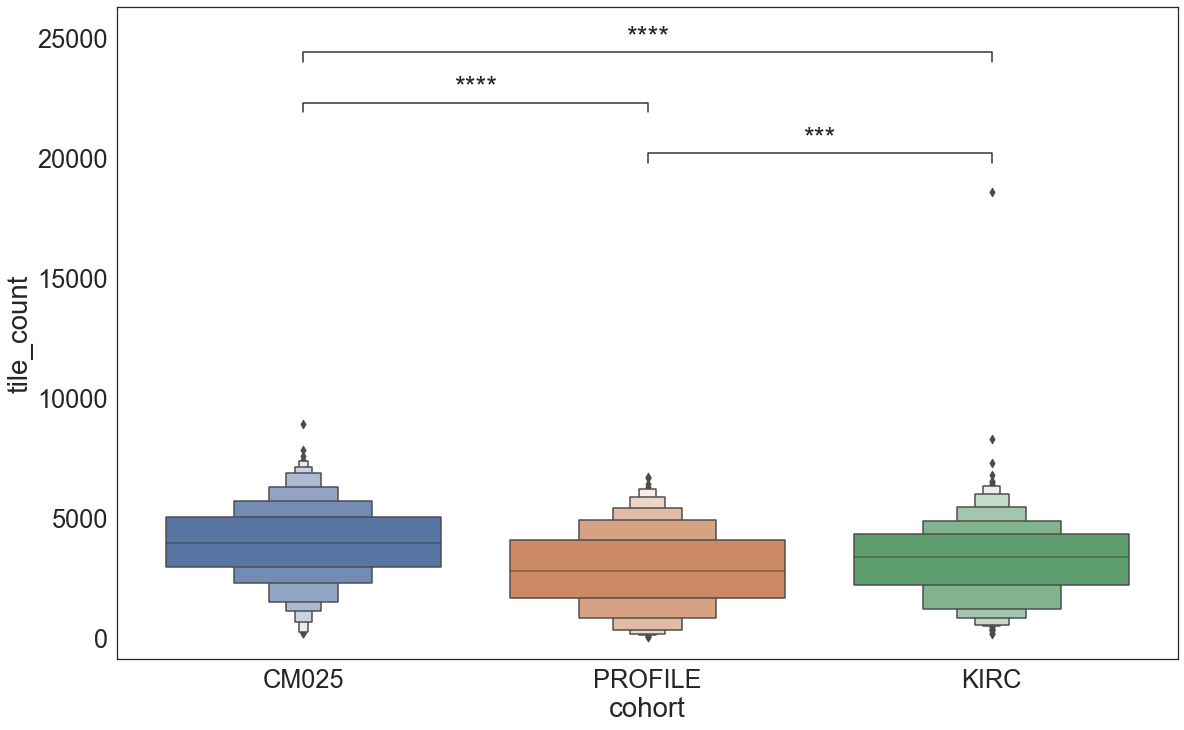

In [141]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
# data = data.loc[(data['stage'] == 'Stage IV')| (data['cohort'] == 'CM025')]

box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'tile_count',
    'data':data,
}

g = sns.boxenplot(**plot_kws)
# move_leg(g)
pairs = list(combinations(['KIRC','CM025','PROFILE'],2))
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}


#### recalculate metrics of tumor tile fraction/count

In [142]:
tilewise = pd.read_csv('./rerun_tilewise_grade_nontil_annotations.csv')
tilewise['meta_num'] = tilewise['merged_labels'] != 0

frac = tilewise.groupby('unique_id')['meta_num'].mean()
frac.name = 'tumor_tile_fraction_re'

count = tilewise.groupby('unique_id')['meta_num'].sum()
count.name = 'tumor_tile_count_re'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PROFILE vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.914e-01 U_stat=5.562e+04
CM025 vs. PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:1.294e-02 U_stat=8.040e+04
CM025 vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.186e-04 U_stat=1.376e+05


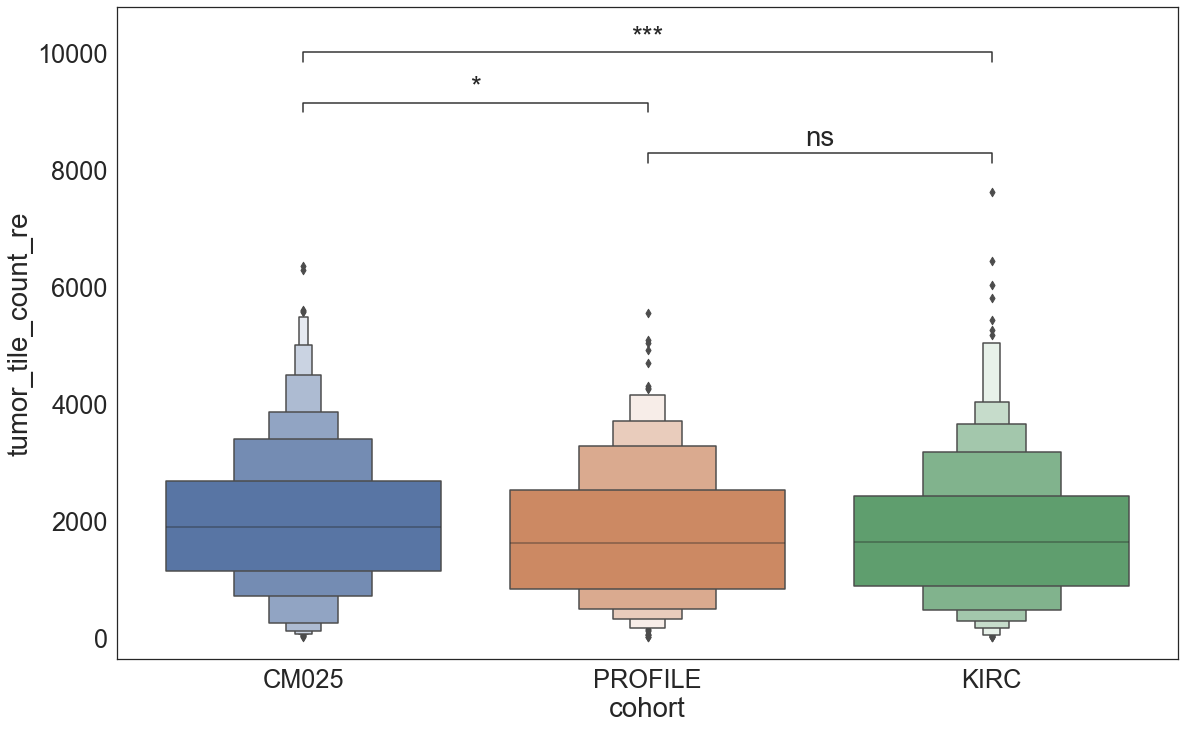

In [143]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
# data = data.loc[(data['stage'] == 'Stage IV')| (data['cohort'] == 'CM025')]
data = data.join(frac)
data = data.join(count)

box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'tumor_tile_count_re',
    'data':data,
}

g = sns.boxenplot(**plot_kws)
# move_leg(g)
pairs = list(combinations(['KIRC','CM025','PROFILE'],2))
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PROFILE vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.064e-01 U_stat=2.014e+03
CM025 vs. PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:7.227e-02 U_stat=1.677e+04
CM025 vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.627e-01 U_stat=1.476e+04


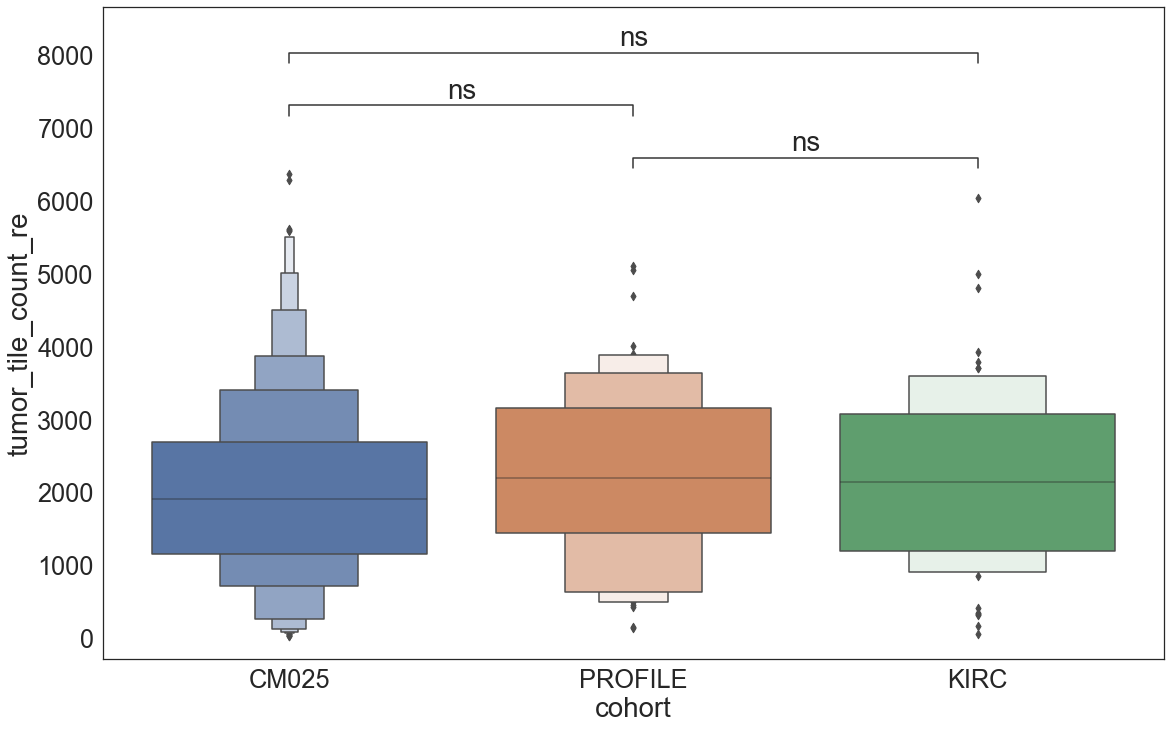

In [144]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
data = data.loc[(data['stage'] == 'Stage IV')| (data['cohort'] == 'CM025')]
data = data.join(frac)
data = data.join(count)

box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'tumor_tile_count_re',
    'data':data,
}

g = sns.boxenplot(**plot_kws)
# move_leg(g)
pairs = list(combinations(['KIRC','CM025','PROFILE'],2))
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PROFILE vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.773e-01 U_stat=5.768e+04
CM025 vs. PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:5.625e-06 U_stat=5.821e+04
CM025 vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.235e-05 U_stat=1.047e+05


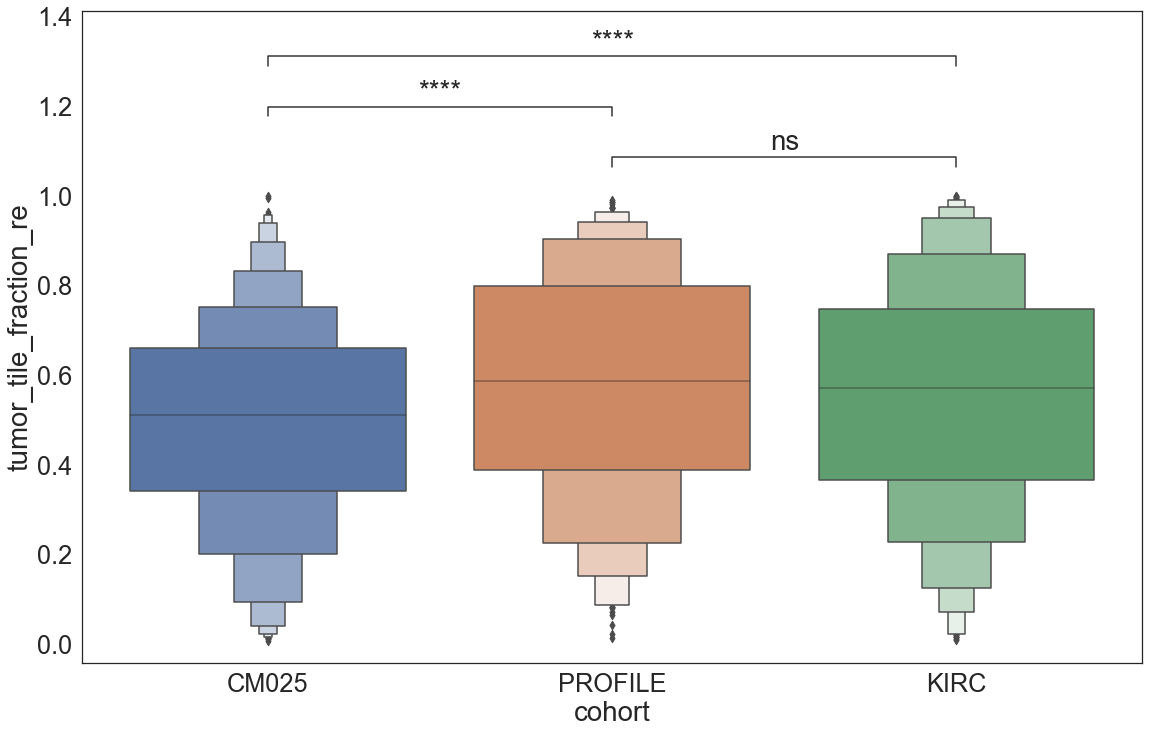

In [145]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
# data = data.loc[(data['stage'] == 'Stage IV')| (data['cohort'] == 'CM025')]
data = data.join(frac)
data = data.join(count)

box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'tumor_tile_fraction_re',
    'data':data,
}

g = sns.boxenplot(**plot_kws)
# move_leg(g)
pairs = list(combinations(['KIRC','CM025','PROFILE'],2))
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PROFILE vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.079e-01 U_stat=2.042e+03
CM025 vs. PROFILE: Mann-Whitney-Wilcoxon test two-sided, P_val:4.272e-04 U_stat=1.429e+04
CM025 vs. KIRC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.915e-03 U_stat=1.286e+04


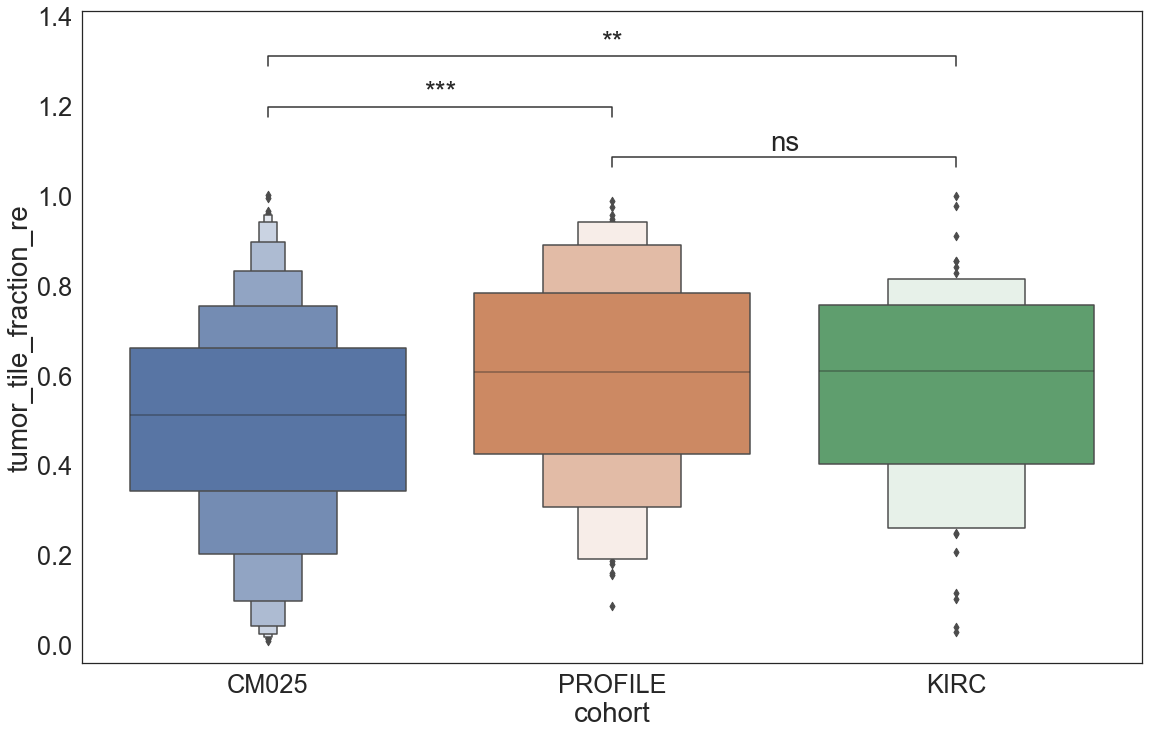

In [146]:
set_rc(19,12, 2.3)
sns.set_style('white')
data = feature_subset.copy()
data['cohort'] = data['cohort'].str.upper()
data = data.loc[(data['stage'] == 'Stage IV')| (data['cohort'] == 'CM025')]
data = data.join(frac)
data = data.join(count)

box_pairs = []
# [box_pairs.extend(list(combinations([(cohort,x) for x in ['G2','G3','G4']], 2))) for cohort in ['KIRC','CM025']]
[box_pairs.extend(list(combinations([(grade,x) for x in ['KIRC','CM025','PROFILE']], 2))) for grade in ['G2','G3','G4']]



plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'tumor_tile_fraction_re',
    'data':data,
}

g = sns.boxenplot(**plot_kws)
# move_leg(g)
pairs = list(combinations(['KIRC','CM025','PROFILE'],2))
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

In [147]:
data.groupby('cohort')['tile_count'].describe()

,count,mean,std,min,25%,50%,75%,max
cohort,,,,,,,,
CM025,623.0,3994.821830,1513.897115,199.0,2961.50,3968.0,5048.0,8902.0
KIRC,61.0,3706.393443,1405.995357,925.0,3033.00,3888.0,4564.0,7292.0
PROFILE,76.0,3347.802632,1639.460952,137.0,2255.25,3204.5,4405.5,6434.0


In [148]:
data.groupby('cohort')['tile_count'].describe()

,count,mean,std,min,25%,50%,75%,max
cohort,,,,,,,,
CM025,623.0,3994.821830,1513.897115,199.0,2961.50,3968.0,5048.0,8902.0
KIRC,61.0,3706.393443,1405.995357,925.0,3033.00,3888.0,4564.0,7292.0
PROFILE,76.0,3347.802632,1639.460952,137.0,2255.25,3204.5,4405.5,6434.0


In [149]:
avg_tumor_prob = tilewise.groupby('unique_id')['smoothed_prob_tumor'].mean()

In [150]:
# data = feature_subset.copy()
data = filtered_agg_data.copy()
data = data.loc[(data['stage'] != 'no_anno') | (data['cohort'] == 'cm025')]
data['stage_collapsed'] = data['stage'].isin(['Stage I','Stage II','Stage III']).map({True:'Stages I-III', False:'Stage IV'})
data = data.join(frac)
data = data.join(count)
data = data.join(avg_tumor_prob)

In [151]:
cols = ['tile_count', 'tumor_tile_count_re','tumor_tile_fraction_re','smoothed_prob_tumor','nonstroma_grade_mean']
data.groupby(['cohort','stage_collapsed'])[cols].median()

tile_count  tumor_tile_count_re  \
cohort  stage_collapsed                                    
cm025   Stage IV             4193.0               1971.0   
kirc    Stage IV             3899.0               2144.0   
        Stages I-III         3607.0               1734.0   
profile Stage IV             3842.0               2232.0   
        Stages I-III         2977.5               1473.0   

                         tumor_tile_fraction_re  smoothed_prob_tumor  \
cohort  stage_collapsed                                                
cm025   Stage IV                       0.504850             0.585972   
kirc    Stage IV                       0.609272             0.679002   
        Stages I-III                   0.536559             0.637174   
profile Stage IV                       0.613031             0.657578   
        Stages I-III                   0.554105             0.643854   

                         nonstroma_grade_mean  
cohort  stage_collapsed                        
cm025   Stage IV                     0.777120  
kirc    Stage IV                     0.696689  
        Stages I-III                 0.434675  
profile Stage IV                     0.695099  
        Stages I-III                 0.405521

In [152]:
data.groupby(['cohort','stage_collapsed'])[cols].mean()

tile_count  tumor_tile_count_re  \
cohort  stage_collapsed                                     
cm025   Stage IV         4288.526196          2088.207289   
kirc    Stage IV         3815.982456          2220.350877   
        Stages I-III     3563.457447          1896.489362   
profile Stage IV         3788.338983          2332.372881   
        Stages I-III     3032.290541          1638.851351   

                         tumor_tile_fraction_re  smoothed_prob_tumor  \
cohort  stage_collapsed                                                
cm025   Stage IV                       0.492756             0.576566   
kirc    Stage IV                       0.572536             0.647713   
        Stages I-III                   0.531798             0.629829   
profile Stage IV                       0.608705             0.648584   
        Stages I-III                   0.568911             0.641345   

                         nonstroma_grade_mean  
cohort  stage_collapsed                        
cm025   Stage IV                     0.734035  
kirc    Stage IV                     0.658562  
        Stages I-III                 0.467901  
profile Stage IV                     0.643192  
        Stages I-III                 0.438601

In [153]:
data.groupby(['stage_collapsed','cohort',])[cols].median()

tile_count  tumor_tile_count_re  \
stage_collapsed cohort                                     
Stage IV        cm025        4193.0               1971.0   
                kirc         3899.0               2144.0   
                profile      3842.0               2232.0   
Stages I-III    kirc         3607.0               1734.0   
                profile      2977.5               1473.0   

                         tumor_tile_fraction_re  smoothed_prob_tumor  \
stage_collapsed cohort                                                 
Stage IV        cm025                  0.504850             0.585972   
                kirc                   0.609272             0.679002   
                profile                0.613031             0.657578   
Stages I-III    kirc                   0.536559             0.637174   
                profile                0.554105             0.643854   

                         nonstroma_grade_mean  
stage_collapsed cohort                         
Stage IV        cm025                0.777120  
                kirc                 0.696689  
                profile              0.695099  
Stages I-III    kirc                 0.434675  
                profile              0.405521

In [154]:
data.groupby(['stage_collapsed','cohort',])[cols].mean()

tile_count  tumor_tile_count_re  \
stage_collapsed cohort                                      
Stage IV        cm025    4288.526196          2088.207289   
                kirc     3815.982456          2220.350877   
                profile  3788.338983          2332.372881   
Stages I-III    kirc     3563.457447          1896.489362   
                profile  3032.290541          1638.851351   

                         tumor_tile_fraction_re  smoothed_prob_tumor  \
stage_collapsed cohort                                                 
Stage IV        cm025                  0.492756             0.576566   
                kirc                   0.572536             0.647713   
                profile                0.608705             0.648584   
Stages I-III    kirc                   0.531798             0.629829   
                profile                0.568911             0.641345   

                         nonstroma_grade_mean  
stage_collapsed cohort                         
Stage IV        cm025                0.734035  
                kirc                 0.658562  
                profile              0.643192  
Stages I-III    kirc                 0.467901  
                profile              0.438601

In [155]:
def get_box_pairs(x_list, hue_list):
    box_pairs = []
    [box_pairs.extend(list(combinations([(x,hue) for hue in hue_list], 2))) for x in x_list]
    return box_pairs

In [156]:
mkdir ./supp_figs

mkdir: cannot create directory ‘./supp_figs’: File exists


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

G3_Stages I-III vs. G3_Stage IV: Mann-Whitney-Wilcoxon test two-sided, P_val:3.909e-02 U_stat=1.259e+03
G2_Stages I-III vs. G2_Stage IV: Mann-Whitney-Wilcoxon test two-sided, P_val:3.562e-02 U_stat=9.800e+01
G4_Stages I-III vs. G4_Stage IV: Mann-Whitney-Wilcoxon test two-sided, P_val:3.544e-01 U_stat=3.100e+02


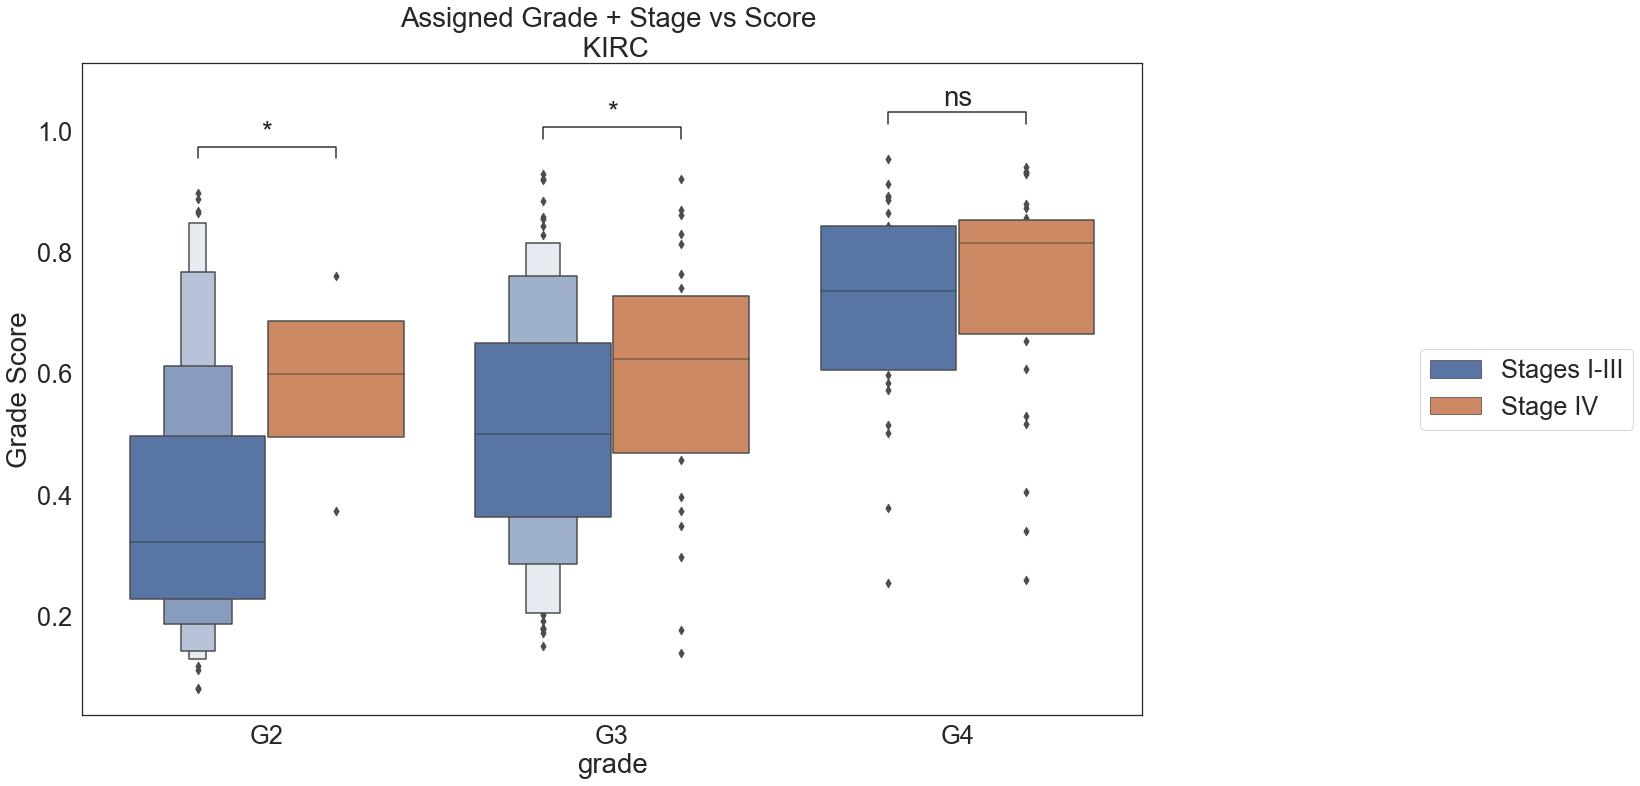

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

G3_Stages I-III vs. G3_Stage IV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.872e-02 U_stat=3.960e+02
G2_Stages I-III vs. G2_Stage IV: Mann-Whitney-Wilcoxon test two-sided, P_val:6.165e-01 U_stat=2.100e+02
G4_Stages I-III vs. G4_Stage IV: Mann-Whitney-Wilcoxon test two-sided, P_val:2.334e-01 U_stat=3.040e+02


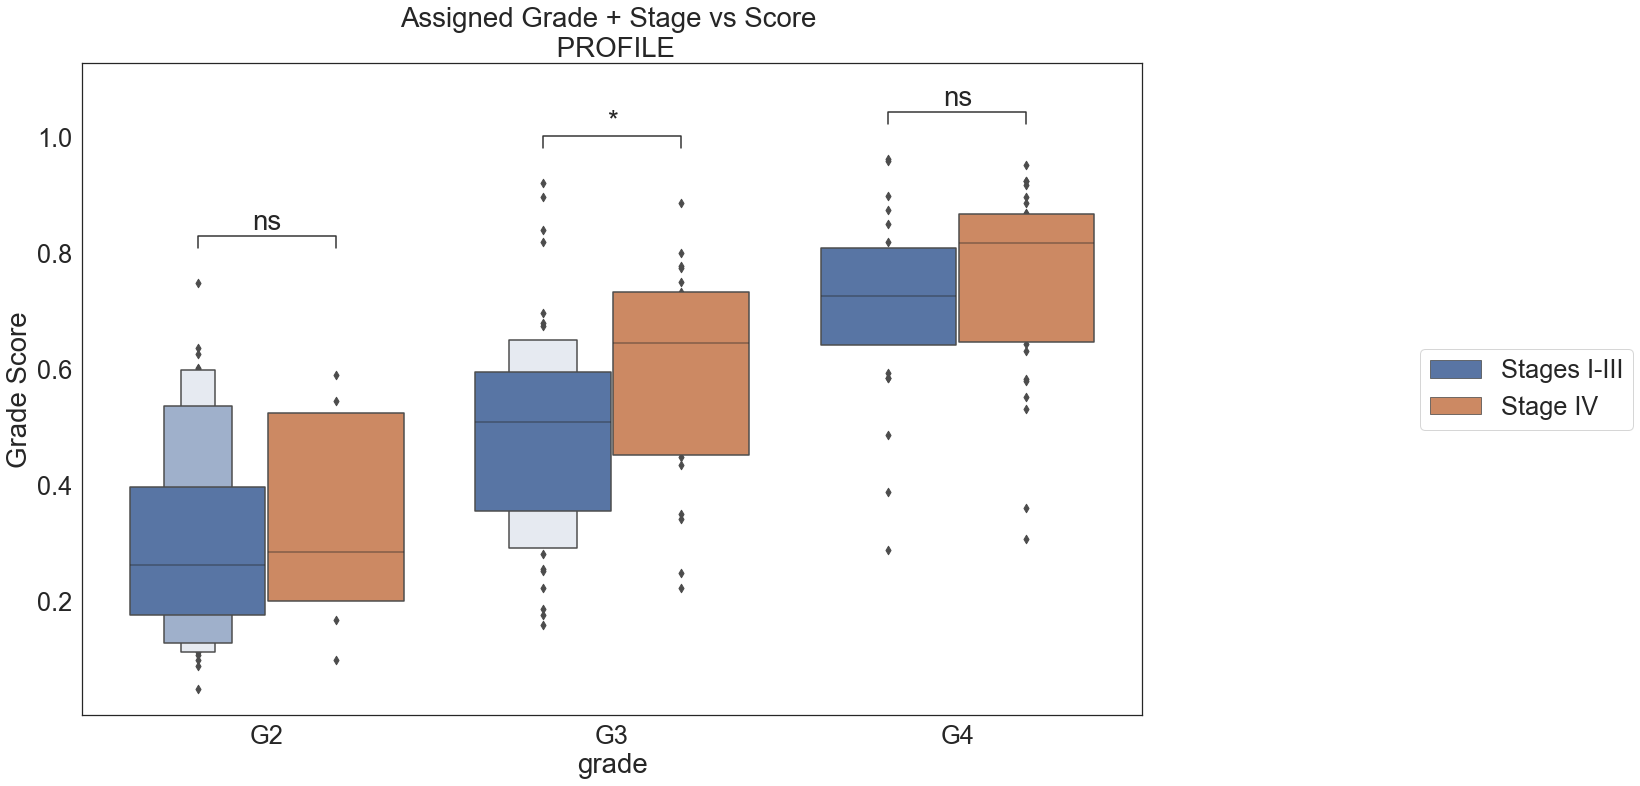

In [157]:
set_rc(19,12, 2.3)
sns.set_style('white')

box_pairs = get_box_pairs(['G2','G3','G4'],['Stages I-III','Stage IV'])

for cohort in ['kirc','profile']:
    plot_kws = {
        'order':['G2','G3','G4'],
        'x':'grade',
        'y':'nonstroma_grade_mean',
        'hue':'stage_collapsed',
        'hue_order':['Stages I-III','Stage IV'],
        'data':data.loc[data.cohort == cohort]
    }

    g = sns.boxenplot(**plot_kws)
    plt.ylabel('Grade Score')
    move_leg(g)
    plt.title(f'Assigned Grade + Stage vs Score \n {cohort.upper()}')
    pairs = box_pairs
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()

    out = unpack_annotator(annotator)
    pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}
    
    plt.savefig(f'./supp_figs/[fig4_related] {cohort} assigned vs grade score vs stage collapsed.pdf', bbox_inches='tight')

    plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:6.685e-03 U_stat=9.750e+03
cm025 vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:2.211e-03 U_stat=1.613e+04
kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:7.655e-01 U_stat=1.736e+03


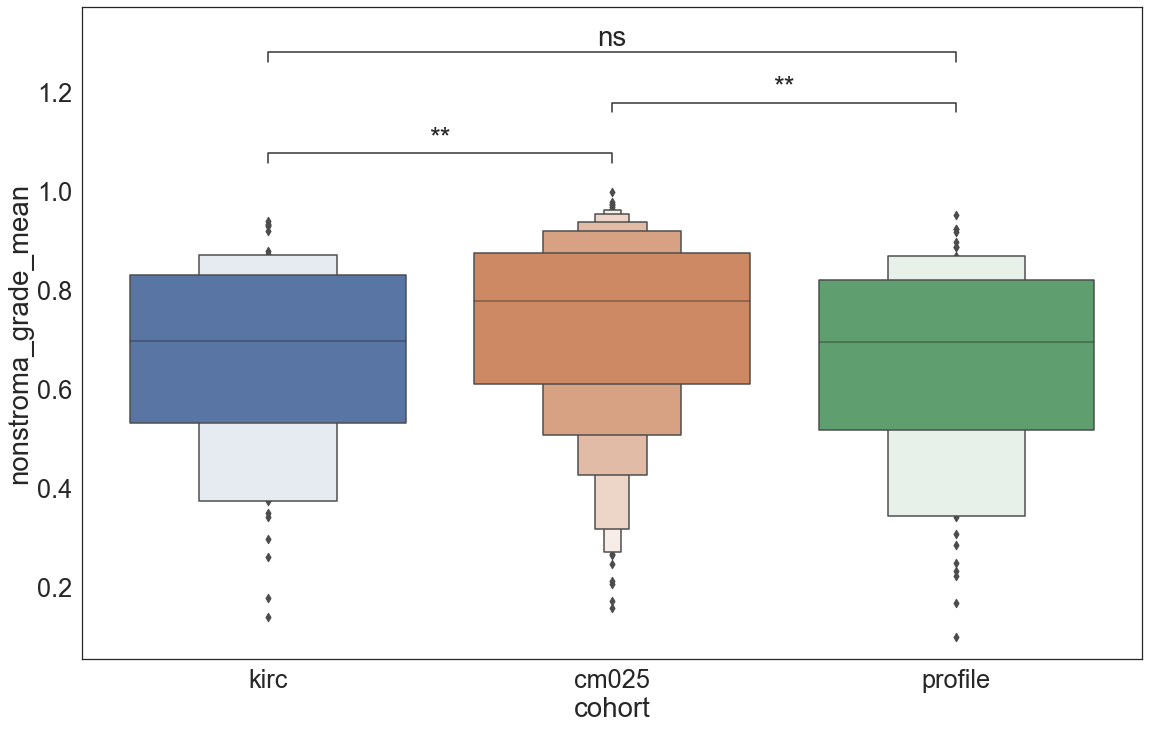

In [158]:
pairs = list(combinations(['kirc','cm025','profile'],2))

plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'nonstroma_grade_mean',
    'data':data.loc[(data['stage_collapsed'] == 'Stage IV')],
}

g = sns.boxenplot(**plot_kws)
# move_leg(g)
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:4.402e-03 U_stat=6.175e+03
profile vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:9.646e-11 U_stat=4.930e+02
kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.068e-07 U_stat=1.404e+03


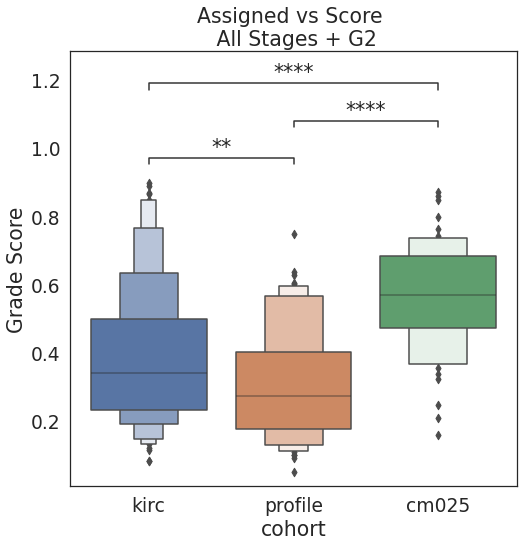

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:8.353e-01 U_stat=5.951e+03
profile vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:2.397e-10 U_stat=7.240e+02
kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:2.867e-11 U_stat=1.600e+03


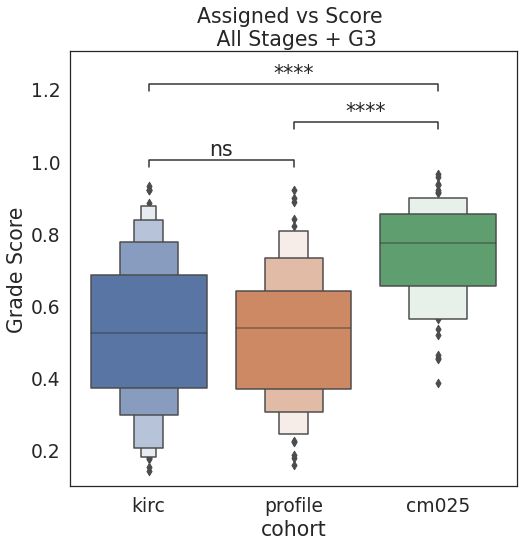

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:8.676e-01 U_stat=1.457e+03
profile vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:7.155e-08 U_stat=7.950e+02
kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:6.136e-08 U_stat=7.700e+02


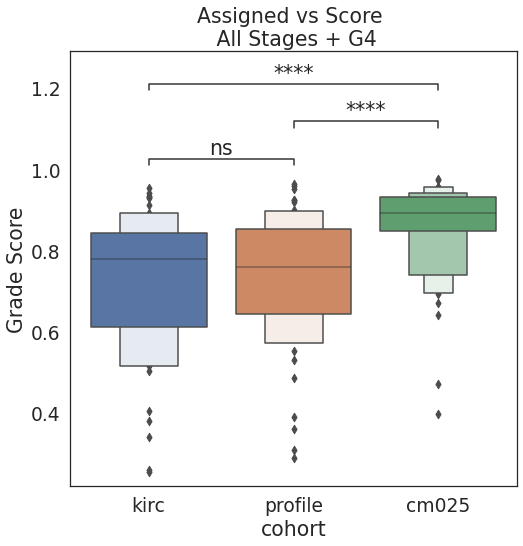

In [159]:
set_rc(8,8, 1.7)
pairs = list(combinations(['kirc','cm025','profile'],2))

for grade in ['G2','G3','G4']:
    plot_kws = {
        'order':['kirc','profile','cm025'],
        'hue':None,
        'x':'cohort',
        'y':'nonstroma_grade_mean',
        'data':data.loc[(data['grade'] == grade)],
    }

    g = sns.boxenplot(**plot_kws)
    plt.ylabel('Grade Score')
    plt.title(f'Assigned vs Score \n All Stages + {grade}')
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()

    out = unpack_annotator(annotator)
    pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}
    plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:1.082e-01 U_stat=2.300e+01
profile vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.364e-02 U_stat=6.500e+01
kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:8.408e-01 U_stat=9.600e+01


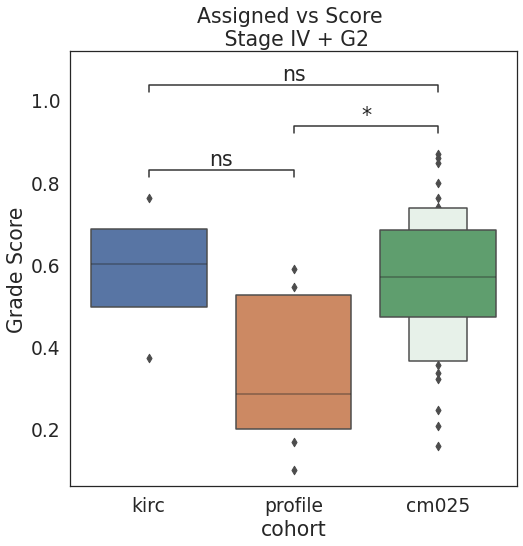

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:9.920e-01 U_stat=2.970e+02
profile vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.120e-03 U_stat=3.090e+02
kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-03 U_stat=4.110e+02


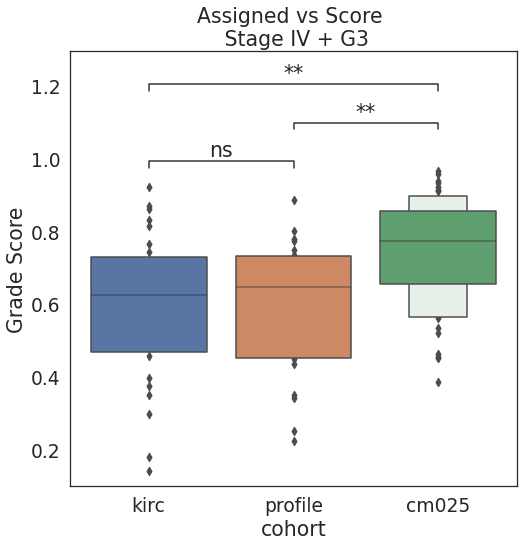

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:8.501e-01 U_stat=3.780e+02
profile vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:5.365e-05 U_stat=4.870e+02
kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.035e-04 U_stat=4.170e+02


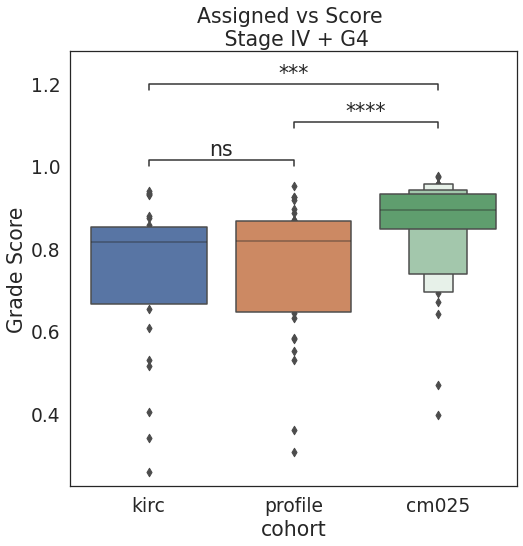

In [160]:
set_rc(8,8, 1.7)
pairs = list(combinations(['kirc','cm025','profile'],2))

for grade in ['G2','G3','G4']:
    plot_kws = {
        'order':['kirc','profile','cm025'],
        'hue':None,
        'x':'cohort',
        'y':'nonstroma_grade_mean',
        'data':data.loc[(data['stage_collapsed'] == 'Stage IV') & (data['grade'] == grade)],
    }

    g = sns.boxenplot(**plot_kws)
    plt.ylabel('Grade Score')
    plt.title(f'Assigned vs Score \n Stage IV + {grade}')
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()

    out = unpack_annotator(annotator)
    pval_str_mapper = {f'[fig1] [mwu]: gradescore vs assigned {k}':v for k,v in out.items()}
    plt.show()

---
### Fig 3C: `any_diff_edge` vs `grade_collapsed`

In [161]:
for duration_var in ['os','pfs']:
    crit = (kirc_pairwise_sweep['col_a']== 'any_diff_edge') & (kirc_pairwise_sweep['col_b']== 'grade_collapsed') 
    crit = crit & (kirc_pairwise_sweep['duration'] == duration_var)
    subset = kirc_pairwise_sweep.loc[crit]
    a = chain_filter_indices(['G2/3'], subset.index.values)
    b = chain_filter_indices(['G4'], subset.index.values)

    for x in [a,b]:
        result_key = f'[fig3c] [pairwise logrank] {x[0][0]} vs. {x[0][1]}'
        result_pval = subset.loc[x,'p'].item()
        print(result_key,result_pval)
        scattered_results[result_key] = result_pval

[fig3c] [pairwise logrank] OS: Heterogeneous + G2/3 vs. OS: Homogeneous + G2/3 0.1219406412369021
[fig3c] [pairwise logrank] OS: Heterogeneous + G4 vs. OS: Homogeneous + G4 0.5812975280279502
[fig3c] [pairwise logrank] PFS: Heterogeneous + G2/3 vs. PFS: Homogeneous + G2/3 0.069944222725654
[fig3c] [pairwise logrank] PFS: Heterogeneous + G4 vs. PFS: Homogeneous + G4 0.5609468491391847


### Fig 3D: `any_diff_edge` vs `quantile_bin_collapsed`

In [162]:
for duration_var in ['os','pfs']:
    crit = (kirc_pairwise_sweep['col_a']== 'any_diff_edge') & (kirc_pairwise_sweep['col_b']== 'quantile_bin_collapsed')
    crit = crit & (kirc_pairwise_sweep['duration'] == duration_var)
    subset = kirc_pairwise_sweep.loc[crit]
    a = chain_filter_indices(['Lower 2/3'], subset.index.values)
    b = chain_filter_indices(['Upper Tercile'], subset.index.values)

    for x in [a,b]:
        result_key = f'[fig3d] [pairwise logrank] {x[0][0]} vs. {x[0][1]}'
        result_pval = kirc_pairwise_sweep.loc[x,'p'].item()
        print(result_key,result_pval)
        scattered_results[result_key] = result_pval

[fig3d] [pairwise logrank] OS: Heterogeneous + Lower 2/3 vs. OS: Homogeneous + Lower 2/3 0.2598130982763286
[fig3d] [pairwise logrank] OS: Heterogeneous + Upper Tercile vs. OS: Homogeneous + Upper Tercile 0.371469187926325
[fig3d] [pairwise logrank] PFS: Heterogeneous + Lower 2/3 vs. PFS: Homogeneous + Lower 2/3 0.0163579317963105
[fig3d] [pairwise logrank] PFS: Heterogeneous + Upper Tercile vs. PFS: Homogeneous + Upper Tercile 0.648932541385979


---

### Fig 4X

### Supp ?? Related to Fig 4: `qbin2` in CM025 

In [163]:
data = pd.read_csv('./[rerun] CM025 - Edge binary status, all splits [Pairwise logrank].csv', index_col=[0,1])

for duration_var in ['os','pfs']:
    crit = (data['col_a']== 'quantile_bin') 
    crit = crit & (data['duration'] == duration_var)
    subset = data.loc[crit]

    for x, row in subset.iterrows():
        result_key = f'[fig4x] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig4x] [pairwise logrank] OS: ICI + quantile_bin_0 vs. OS: ICI + quantile_bin_1 0.0176991006763947
[fig4x] [pairwise logrank] OS: Non-ICI + quantile_bin_0 vs. OS: Non-ICI + quantile_bin_1 0.0281792846089696
[fig4x] [pairwise logrank] PFS: ICI + quantile_bin_0 vs. PFS: ICI + quantile_bin_1 0.4189960161462623
[fig4x] [pairwise logrank] PFS: Non-ICI + quantile_bin_0 vs. PFS: Non-ICI + quantile_bin_1 0.5689154492370941


### Text body re: fig 4 

In [164]:
feature_subset.loc[feature_subset['cohort'] == 'cm025']

,tile_count,cohort,tumor_tile_fraction,tumor_tile_count,pfs,pfs_event,os,os_event,ttf,ttf_event,...,proximal_hg_bin,distal_hg_bin,any_hg_diff_edge,any_hg_distal_edge,any_hg_proximal_edge,distal_edge_detailed,global_infiltration_bin,proximal_edge_detailed,candidate_category,tcga_ricketts_grade
unique_id,,,,,,,,,,,,,,,,,,,,,
cm025_1,5028,cm025,0.667064,3354,14.718686,1.0,66.924025,0.0,14.718686,1.0,...,no_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,low_hg_global_infiltration,no_high_grade_proximal_edge,passing,NaN
cm025_1000,4334,cm025,0.850023,3684,7.162218,1.0,53.223819,0.0,7.162218,1.0,...,nonpassing_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,no_hg_present,no_high_grade_proximal_edge,passing,NaN
cm025_1001,2336,cm025,0.764127,1785,3.712526,1.0,24.246407,1.0,3.712526,1.0,...,nonpassing_proximal_edge,distal_hg_noninfiltrated,high_grade_diff_edge,True,False,high_grade_distal_edge,low_hg_global_infiltration,no_high_grade_proximal_edge,passing,NaN
cm025_1002,2007,cm025,0.200299,402,36.172485,0.0,52.731006,0.0,36.172485,0.0,...,no_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,high_hg_global_infiltration,no_high_grade_proximal_edge,passing,NaN
cm025_1006,5936,cm025,0.281840,1673,2.069815,1.0,52.665298,0.0,2.069815,1.0,...,no_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,high_hg_global_infiltration,no_high_grade_proximal_edge,passing,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cm025_991,5952,cm025,0.625504,3723,4.599589,1.0,53.092402,0.0,4.599589,1.0,...,nonpassing_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,no_hg_present,no_high_grade_proximal_edge,passing,NaN
cm025_992,2826,cm025,0.746285,2109,1.741273,1.0,13.338809,1.0,1.741273,1.0,...,no_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,high_hg_global_infiltration,no_high_grade_proximal_edge,passing,NaN
cm025_995,5770,cm025,0.430676,2485,5.519507,1.0,19.679671,1.0,5.519507,1.0,...,no_proximal_edge,no_distal_edge,no_high_grade_diff_edge,False,False,no_high_grade_distal_edge,low_hg_global_infiltration,no_high_grade_proximal_edge,passing,NaN


In [165]:
feature_subset.value_counts(['cohort','primary_site','usable_nontil_data'], sort=False)

cohort   primary_site  usable_nontil_data
cm025    False         False                  23
                       True                  129
         True          False                  31
                       True                  440
kirc     True          False                  34
                       True                  431
profile  False         False                  19
                       True                   47
         True          False                  30
                       True                  208
dtype: int64

In [166]:
df = pd.concat([checkmate_data, kirc_data])
df = df.loc[df['grade'] != 'GX']
df['is_g4'] = df['grade'] == 'G4'

col_a = 'is_g4'
col_b = 'cohort'
conting = pd.DataFrame(df.value_counts([col_a,col_b]), columns=['count']).reset_index()
conting = conting.pivot_table(columns=[col_b], index=col_a, values='count')
print(conting)

odds, result_pval = calc_fisher_alt(conting)

result_key = f'[fig4x] [fisher] TCGA vs CM025: proportion G4 in usable primary site data'
print(result_key, result_pval)
scattered_results[result_key] = result_pval

cohort  cm025  kirc
is_g4              
False      99   356
True       67    63
[fig4x] [fisher] TCGA vs CM025: proportion G4 in usable primary site data 2.462387820165568e-10


In [167]:
print(f'% G4 in CM-025: {61/(61+96) :.2f}')

% G4 in CM-025: 0.39


In [168]:
print(f'% G4 in TCGA-KIRC: {58/(58+312) :.2f}')

% G4 in TCGA-KIRC: 0.16


means:
cohort
cm025      0.734035
kirc       0.483043
profile    0.495217
Name: nonstroma_grade_mean, dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:1.522e-51 U_stat=3.741e+04
cm025 vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:1.463e-30 U_stat=7.117e+04
kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:5.566e-01 U_stat=4.252e+04


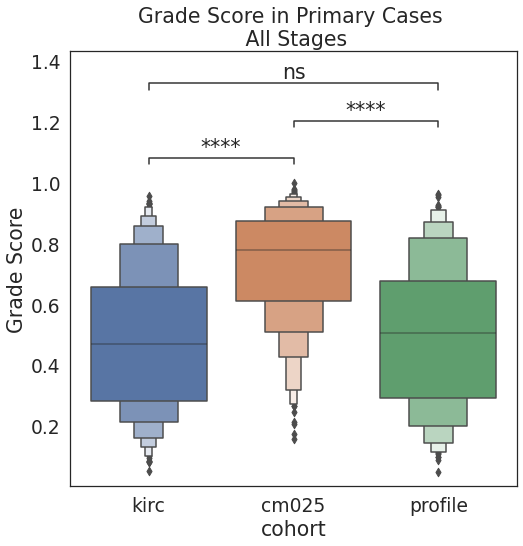

In [169]:
set_rc(8,8,1.7)
data = filtered_agg_data.copy()

pairs = list(combinations(['kirc','cm025','profile'],2))

plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'nonstroma_grade_mean',
    'data':data,
}

print('means:')
print(data.groupby('cohort')['nonstroma_grade_mean'].mean())
score_means = data.groupby('cohort')['nonstroma_grade_mean'].mean().to_dict()
pval_str_mapper = {f'[fig4x] [mean]: global cohort grade score [primary + usable nontil + all stages] {k}':v for k,v in score_means.items()}
scattered_results.update(pval_str_mapper)

g = sns.boxenplot(**plot_kws)
# move_leg(g)
plt.title('Grade Score in Primary Cases \n All Stages')
plt.ylabel('Grade Score')
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)

pval_str_mapper = {f'[fig4x] [mwu]: global cohort grade score [primary + usable nontil + all stages] {k}':v for k,v in out.items()}
plt.savefig('./supp_figs/[fig4_related] global cohort grade score [primary + usable nontil + all stages].pdf', bbox_inches='tight')


means:
cohort
cm025      0.734035
kirc       0.658562
profile    0.643192
Name: nonstroma_grade_mean, dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

kirc vs. cm025: Mann-Whitney-Wilcoxon test two-sided, P_val:6.685e-03 U_stat=9.750e+03
cm025 vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:2.211e-03 U_stat=1.613e+04
kirc vs. profile: Mann-Whitney-Wilcoxon test two-sided, P_val:7.655e-01 U_stat=1.736e+03


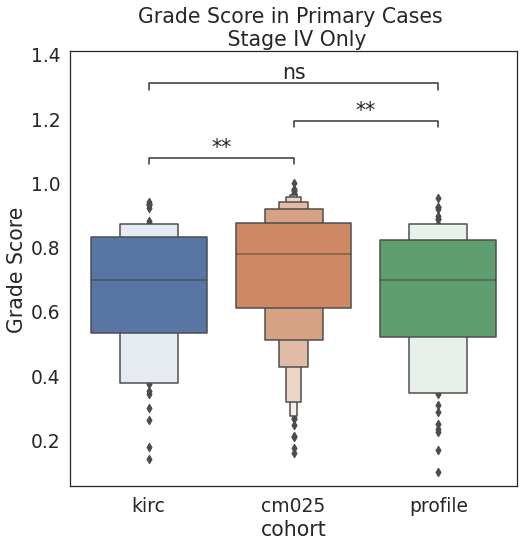

In [170]:
set_rc(8,8,1.7)
data = filtered_agg_data.copy()
data = data.loc[(data['stage'] != 'no_anno') | (data['cohort'] == 'cm025')]
data['stage_collapsed'] = data['stage'].isin(['Stage I','Stage II','Stage III']).map({True:'Stages I-III', False:'Stage IV'})

pairs = list(combinations(['kirc','cm025','profile'],2))

plot_kws = {
    'order':None,
    'hue':None,
    'x':'cohort',
    'y':'nonstroma_grade_mean',
    'data':data.loc[data['stage_collapsed'] == 'Stage IV'],
}

print('means:')
print(data.loc[data['stage_collapsed'] == 'Stage IV'].groupby('cohort')['nonstroma_grade_mean'].mean())
score_means = data.loc[data['stage_collapsed'] == 'Stage IV'].groupby('cohort')['nonstroma_grade_mean'].mean().to_dict()
pval_str_mapper = {f'[fig4x] [mean]: global cohort grade score [primary + usable nontil + Stage IV only] {k}':v for k,v in score_means.items()}
scattered_results.update(pval_str_mapper)

g = sns.boxenplot(**plot_kws)
# move_leg(g)
plt.title('Grade Score in Primary Cases \n Stage IV Only')
plt.ylabel('Grade Score')
annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

out = unpack_annotator(annotator)
pval_str_mapper = {f'[fig4x] [mwu]: global cohort grade score [primary + usable nontil + Stage IV only] {k}':v for k,v in out.items()}
plt.savefig('./supp_figs/[fig4_related] global cohort grade score [primary + usable nontil + Stage IV only].pdf', bbox_inches='tight')
scattered_results.update(pval_str_mapper)

### Fig 4A: `any_diff_edge` in CM025 

In [171]:
data = pd.read_csv('./[rerun] CM025 - Edge binary status, all splits [Pairwise logrank].csv', index_col=[0,1])

for duration_var in ['os','pfs']:
    crit = (data['col_a']== 'any_diff_edge') 
    crit = crit & (data['duration'] == duration_var)
    subset = data.loc[crit]

    for x, row in subset.iterrows():
        result_key = f'[fig4a] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig4a] [pairwise logrank] OS: ICI + Heterogeneous vs. OS: ICI + Homogeneous 0.0178992917903433
[fig4a] [pairwise logrank] OS: Non-ICI + Heterogeneous vs. OS: Non-ICI + Homogeneous 0.1295193900559943
[fig4a] [pairwise logrank] PFS: ICI + Heterogeneous vs. PFS: ICI + Homogeneous 0.0306886912136959
[fig4a] [pairwise logrank] PFS: Non-ICI + Heterogeneous vs. PFS: Non-ICI + Homogeneous 0.907992767648134


### Fig 4B: `any_diff_edge` + `subgroup_qbin` in CM025 

In [172]:
data = pd.read_csv('./[rerun] CM025 - Edge binary status x QBIN, all splits including_intermediate_benefit [Pairwise logrank].csv', index_col=[0,1])

#### CM025: any_diff_edge [T] vs subgroup_qbin

In [173]:
for duration_var in ['os','pfs']:
    crit = (data['col_a']== 'any_diff_edge') & (data['col_b']== 'subgroup_qbin') 
    crit = crit & (data['duration'] == duration_var)
    subset = data.loc[crit]
    filtered_indices = chain_filter_indices(['Heterogeneous'],subset.index.values)
    subset = subset.loc[filtered_indices]
    
    for x, row in subset.iterrows():
        result_key = f'[fig4b] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig4b] [pairwise logrank] OS: ICI + Heterogeneous + Higher (Relative) vs. OS: ICI + Heterogeneous + Lower (Relative) 0.1774248837235756
[fig4b] [pairwise logrank] OS: Non-ICI + Heterogeneous + Higher (Relative) vs. OS: Non-ICI + Heterogeneous + Lower (Relative) 0.9218055379431964
[fig4b] [pairwise logrank] PFS: ICI + Heterogeneous + Higher (Relative) vs. PFS: ICI + Heterogeneous + Lower (Relative) 0.5261189147363232
[fig4b] [pairwise logrank] PFS: Non-ICI + Heterogeneous + Higher (Relative) vs. PFS: Non-ICI + Heterogeneous + Lower (Relative) 0.5298758507932553


#### CM025: any_diff_edge [F] vs subgroup_qbin

In [174]:
for duration_var in ['os','pfs']:
    crit = (data['col_a']== 'any_diff_edge') & (data['col_b']== 'subgroup_qbin') 
    crit = crit & (data['duration'] == duration_var)
    subset = data.loc[crit]
    filtered_indices = chain_filter_indices(['Homogeneous'],subset.index.values)
    subset = subset.loc[filtered_indices]
    
    for x, row in subset.iterrows():
        result_key = f'[fig4b] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig4b] [pairwise logrank] OS: ICI + Homogeneous + Higher (Relative) vs. OS: ICI + Homogeneous + Lower (Relative) 0.2570362432345397
[fig4b] [pairwise logrank] OS: Non-ICI + Homogeneous + Higher (Relative) vs. OS: Non-ICI + Homogeneous + Lower (Relative) 0.1742054066660064
[fig4b] [pairwise logrank] PFS: ICI + Homogeneous + Higher (Relative) vs. PFS: ICI + Homogeneous + Lower (Relative) 0.4025243970129443
[fig4b] [pairwise logrank] PFS: Non-ICI + Homogeneous + Higher (Relative) vs. PFS: Non-ICI + Homogeneous + Lower (Relative) 0.8292302142588863


### Fig 5: OS ICI `HG GradeHet + hiTIL` vs `rest`

### Fig 5: PFS ICI `HG GradeHet + hiTIL` vs `rest`

In [175]:
data = pd.read_csv('./[rerun] CM025 - Edge binary status + TIL binary status, all splits including_intermediate_benefit [Pairwise logrank].csv', index_col=[0,1])
data

test_statistic  \
OS: ICI + Heterogeneous +                          OS: ICI + Homogeneous +                                   3.752443   
OS: Non-ICI + Heterogeneous +                      OS: Non-ICI + Homogeneous +                               0.413776   
PFS: ICI + Heterogeneous +                         PFS: ICI + Homogeneous +                                  3.997031   
PFS: Non-ICI + Heterogeneous +                     PFS: Non-ICI + Homogeneous +                              0.194316   
OS: ICI + Heterogeneous + high_hg_global_infilt... OS: ICI + Heterogeneous + low_hg_global_infiltr...        0.855355   
...                                                                                                               ...   
PFS: Non-ICI + low/hi foci contact [distal] + h... PFS: Non-ICI + no low/hi foci contact [distal] ...        0.142788   
                                                   PFS: Non-ICI + no low/hi foci contact [distal] ...        0.718353   
PFS: Non-ICI + low/hi foci contact [distal] + l... PFS: Non-ICI + no low/hi foci contact [distal] ...        0.566534   
                                                   PFS: Non-ICI + no low/hi foci contact [distal] ...        0.515297   
PFS: Non-ICI + no low/hi foci contact [distal] ... PFS: Non-ICI + no low/hi foci contact [distal] ...        0.014373   

                                                                                                              p  \
OS: ICI + Heterogeneous +                          OS: ICI + Homogeneous +                             0.052730   
OS: Non-ICI + Heterogeneous +                      OS: Non-ICI + Homogeneous +                         0.520059   
PFS: ICI + Heterogeneous +                         PFS: ICI + Homogeneous +                            0.045580   
PFS: Non-ICI + Heterogeneous +                     PFS: Non-ICI + Homogeneous +                        0.659349   
OS: ICI + Heterogeneous + high_hg_global_infilt... OS: ICI + Heterogeneous + low_hg_global_infiltr...  0.355042   
...                                                                                                         ...   
PFS: Non-ICI + low/hi foci contact [distal] + h... PFS: Non-ICI + no low/hi foci contact [distal] ...  0.705525   
                                                   PFS: Non-ICI + no low/hi foci contact [distal] ...  0.396685   
PFS: Non-ICI + low/hi foci contact [distal] + l... PFS: Non-ICI + no low/hi foci contact [distal] ...  0.451640   
                                                   PFS: Non-ICI + no low/hi foci contact [distal] ...  0.472855   
PFS: Non-ICI + no low/hi foci contact [distal] ... PFS: Non-ICI + no low/hi foci contact [distal] ...  0.904574   

                                                                                                       -log2(p)  \
OS: ICI + Heterogeneous +                          OS: ICI + Homogeneous +                             4.245221   
OS: Non-ICI + Heterogeneous +                      OS: Non-ICI + Homogeneous +                         0.943252   
PFS: ICI + Heterogeneous +                         PFS: ICI + Homogeneous +                            4.455440   
PFS: Non-ICI + Heterogeneous +                     PFS: Non-ICI + Homogeneous +                        0.600886   
OS: ICI + Heterogeneous + high_hg_global_infilt... OS: ICI + Heterogeneous + low_hg_global_infiltr...  1.493939   
...                                                                                                         ...   
PFS: Non-ICI + low/hi foci contact [distal] + h... PFS: Non-ICI + no low/hi foci contact [distal] ...  0.503231   
                                                   PFS: Non-ICI + no low/hi foci contact [distal] ...  1.333936   
PFS: Non-ICI + low/hi foci contact [distal] + l... PFS: Non-ICI + no low/hi foci contact [distal] ...  1.146756   
                                                   PFS: Non-ICI + no low/hi foci contact [distal] ...  1.080531   
PFS:

In [176]:
for duration_var in ['os','pfs']:
    subset = data.loc[(data['col_a'] == 'is_hghet_hiTIL' ) & (data['col_b'] == 'dummy' ) & (data['duration'] == duration_var)]
    for x, row in subset.iterrows():
        result_key = f'[fig5] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig5] [pairwise logrank] OS: ICI + HG GradeHet + High Infiltration +  vs. OS: ICI + Rest +  0.0219851022274621
[fig5] [pairwise logrank] OS: Non-ICI + HG GradeHet + High Infiltration +  vs. OS: Non-ICI + Rest +  0.8532561762789537
[fig5] [pairwise logrank] PFS: ICI + HG GradeHet + High Infiltration +  vs. PFS: ICI + Rest +  0.0661584561883679
[fig5] [pairwise logrank] PFS: Non-ICI + HG GradeHet + High Infiltration +  vs. PFS: Non-ICI + Rest +  0.7573371431003963


In [177]:
# for duration_var in ['os','pfs']:
#     subset = data.loc[(data['col_a'] == 'any_hg_diff_edge') & (data['col_b'] == 'global_infiltration_bin') & (data['duration'] == duration_var)]
#     for x, row in subset.iterrows():
#         result_key = f'[fig5] [pairwise logrank] {x[0]} vs. {x[1]}'
#         result_pval = row['p']
#         print(result_key, result_pval)
#         scattered_results[result_key] = result_pval

### Fig 5: OS ICI low vs high infiltration in `hg_diff_edge` [T]

### Fig 5: PFS ICI low vs high infiltration in `hg_diff_edge` [T]

In [178]:
for duration_var in ['os','pfs']:
    subset = data.loc[(data['col_a'] == 'any_hg_diff_edge')]
    subset = subset.loc[chain_filter_indices([duration_var.upper(),' ICI',' Heterogeneous'], subset.index.values)]
    for x, row in subset.iterrows():
        result_key = f'[fig5] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig5] [pairwise logrank] OS: ICI + Heterogeneous + high_hg_global_infiltration vs. OS: ICI + Heterogeneous + low_hg_global_infiltration 0.1231393977311912
[fig5] [pairwise logrank] PFS: ICI + Heterogeneous + high_hg_global_infiltration vs. PFS: ICI + Heterogeneous + low_hg_global_infiltration 0.2550610026020978


### Fig 5: OS ICI low vs high infiltration in `hg_diff_edge` [F]

### Fig 5: PFS ICI low vs high infiltration in `hg_diff_edge` [F]

In [179]:
for duration_var in ['os','pfs']:
    subset = data.loc[(data['col_a'] == 'any_hg_diff_edge')]
    subset = subset.loc[chain_filter_indices([duration_var.upper(),' ICI',' Homogeneous'], subset.index.values)]
    for x, row in subset.iterrows():
        result_key = f'[fig5] [pairwise logrank] {x[0]} vs. {x[1]}'
        result_pval = row['p']
        print(result_key, result_pval)
        scattered_results[result_key] = result_pval

[fig5] [pairwise logrank] OS: ICI + Homogeneous + high_hg_global_infiltration vs. OS: ICI + Homogeneous + low_hg_global_infiltration 0.9345069856148378
[fig5] [pairwise logrank] PFS: ICI + Homogeneous + high_hg_global_infiltration vs. PFS: ICI + Homogeneous + low_hg_global_infiltration 0.5720775172383863


## Supplement: PBRM1 vs Heterogeneity

In [180]:
til_semantic_cols = ['highly_infiltrated_dispersed', 'intermed_infiltrated_dispersed',
       'localized_infiltration', 'low_infiltrated_dispersed',
       'non_infiltrated']

rag_feature_cols = [ 
    'edge_class_proximal','edge_class_distal',
    'largest_cc_size', 'avg_degree',
    'high_amidst_low_count', 'high_bordering_low_count', 
    'isolated_count',
    'low_amidst_high_count', 'low_bordering_high_count',
       ]

combined_info_cols = [
    'combined_rag_differential_label','total_foci_infiltration_label'
]

rag_feature_formula = ' + '.join(rag_feature_cols)
til_semantic_feature_formula = ' + '.join(til_semantic_cols)
combined_feature_formula = ' + '.join(combined_info_cols)

die_edge_cols = ['distal_both_excluded_or_desert', 'distal_both_infiltrated',
       'distal_diff_contact_infiltrated_excluded_or_desert',
       'proximal_both_excluded_or_desert', 'proximal_both_infiltrated',
       'proximal_diff_contact_infiltrated_excluded_or_desert',
       'diff_contact_infiltrated_excluded_or_desert',
       'both_excluded_or_desert', 'both_infiltrated']

score_cols = ['proximal_grade_diff_and_area_weighted', 'proximal_area_weighted',
       'proximal_higher_hg_infiltration', 'proximal_lower_hg_infiltration',
       'proximal_no_hg_infiltration', 'distal_grade_diff_and_area_weighted',
       'distal_area_weighted', 'distal_higher_hg_infiltration',
       'distal_lower_hg_infiltration', 'distal_no_hg_infiltration',
       'isolated_only_area_weighted', 'all_nodes_area_weighted']

edge_score_cols = [
    'proximal_grade_diff_and_area_weighted',
    'proximal_area_weighted',
    'distal_grade_diff_and_area_weighted',
    'distal_area_weighted',
    'proximal_edgemean_infiltration_and_area_weighted',
    'proximal_edgemean_infiltration_grade_abs_diff_and_area_weighted',
    'distal_edgemean_infiltration_and_area_weighted',
    'distal_edgemean_infiltration_grade_abs_diff_and_area_weighted'
]



revised_rag_fts = ['largest_cc_size', 'avg_degree']
revised_rag_fts += ['desert_freq_manual_cutoff', 'excluded_freq_manual_cutoff', 'infiltrated_freq_manual_cutoff']
cph_fts = revised_rag_fts + ['nonstroma_grade_mean']

In [181]:
outcome_type = 'recist'
duration_var = 'pfs'
event_var = duration_var+'_event'
risk_type = 'MSKCC'
# mandatory_vars = ['age_at_diagnosis','gender','n_prior_therapy']
mandatory_vars = []

high_grade_filter = False
til_only_cases = False
drop_met_site = True
gene = 'PBRM1'
qbins = 2
drug_type = 'ICI'
drop_intermed_group = False



fill_value = 0.

data_subset = feature_subset.copy()
temp = prepare_cm025_subset(data_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter, qbins=qbins)



print('adding combined __-weighted scores')
temp['combined_f_weighted_edge_score'] = temp['edge_class_proximal_f_weighted'] + temp['edge_class_distal_f_weighted']
temp['combined_total_weighted_edge_score'] = temp['edge_class_proximal_total_weighted'] + temp['edge_class_distal_total_weighted']

print('zero-filling and rescaling features')
unscaled_cols = ['age_at_diagnosis','edge_class_proximal_f_weighted','edge_class_distal_f_weighted',
                 'all_nodes_area_weighted','edge_class_proximal_total_weighted','edge_class_distal_total_weighted', 'total_nodes',
                'combined_f_weighted_edge_score','combined_total_weighted_edge_score']

temp[unscaled_cols] = temp[unscaled_cols].fillna(fill_value)  # need placeholders for NaNs for quant features
print(temp.shape)

temp[unscaled_cols] = run_cph_feature_scaling(temp, unscaled_cols)


# manually set category orders s/t first category is baseline
s = temp['any_hg_diff_edge'].astype('category')
s = s.cat.reorder_categories(['no_high_grade_diff_edge','high_grade_diff_edge'], ordered=True)
temp['any_hg_diff_edge'] = s

s = temp['any_diff_edge'].astype('category')
s = s.cat.reorder_categories(['No Mixed Foci Presence','Low/Hi Presence'], ordered=True)
temp['any_diff_edge'] = s

s = temp['any_proximal_edge'].astype('category')
s = s.cat.reorder_categories(['No Low/Hi Foci Contact [Proximal]','Low/Hi Foci Contact [Proximal]'], ordered=True)
temp['any_proximal_edge'] = s

s = temp['any_distal_edge'].astype('category')
s = s.cat.reorder_categories(['no low/hi foci contact [distal]','low/hi foci contact [distal]'], ordered=True)
temp['any_distal_edge'] = s

# s = temp['global_infiltration_bin'].astype('category')
# s = s.cat.reorder_categories(['low_hg_global_infiltration','high_hg_global_infiltration'], ordered=True)
# temp['global_infiltration_bin'] = s

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['pfs', 'pfs_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
taking only PBRM1 Mut/WT info available cases
(276, 150)
only taking ICI arm
(138, 150)
converting bool edge presence labels to string
adding combined __-weighted scores
zero-filling and rescaling features
(138, 154)
Running StandardScaler


In [182]:
wt_sub = temp.loc[temp['PBRM1'] == 'WT']
mut_sub = temp.loc[temp['PBRM1'] == 'MUT']

`any_diff_edge` and combined total-weighted het score

#### OS, `any_diff_edge`

#### PFS, `any_diff_edge`

In [183]:
l1_ratio = 0
penalizer = 0

for formula in ['any_diff_edge', 'combined_total_weighted_edge_score']:
    for duration_var in ['os','pfs']:
        event_var = duration_var+'_event'
        wt_out = run_cph_comparison_multivar(wt_sub, duration_var, event_var, covariate_formula=formula, penalizer=penalizer, l1_ratio=l1_ratio)
        
        # wald test pval 
        result_key = f'[supp] [cph wald coef test] [{duration_var.upper()}] PBRM WT {formula} univariate'
        result_pval = wt_out.summary['p'].item()
        
        # loglikelihood ratio test (asymptotically equivalent https://stats.stackexchange.com/questions/373932/different-p-values-for-coefficients-and-lrt-in-univariate-cox-regression-coxph)
        result_key_alt = f'[supp] [cph LLRT] [{duration_var.upper()}] PBRM WT {formula} univariate'
        result_pval_alt = wt_out.log_likelihood_ratio_test().summary['p'].item()
        print(result_key, result_pval)
        print(result_key_alt, result_pval_alt)

        scattered_results[result_key] = result_pval
        scattered_results[result_key_alt] = result_pval_alt
        
        
        mut_out = run_cph_comparison_multivar(mut_sub, duration_var, event_var, covariate_formula=formula, penalizer=penalizer, l1_ratio=l1_ratio)
        
        # wald test pval 
        result_key = f'[supp] [cph wald coef test] [{duration_var.upper()}] PBRM MUT {formula} univariate'
        result_pval = mut_out.summary['p'].item()
        
        # loglikelihood ratio test (asymptotically equivalent https://stats.stackexchange.com/questions/373932/different-p-values-for-coefficients-and-lrt-in-univariate-cox-regression-coxph)
        result_key_alt = f'[supp] [cph LLRT] [{duration_var.upper()}] PBRM MUT {formula} univariate'
        result_pval_alt = mut_out.log_likelihood_ratio_test().summary['p'].item()
        print(result_key, result_pval)
        print(result_key_alt, result_pval_alt)
        scattered_results[result_key] = result_pval
        scattered_results[result_key_alt] = result_pval_alt

[supp] [cph wald coef test] [OS] PBRM WT any_diff_edge univariate 0.021160888336615342
[supp] [cph LLRT] [OS] PBRM WT any_diff_edge univariate 0.015366699165193069
[supp] [cph wald coef test] [OS] PBRM MUT any_diff_edge univariate 0.9824026165612125
[supp] [cph LLRT] [OS] PBRM MUT any_diff_edge univariate 0.9822212603468774
[supp] [cph wald coef test] [PFS] PBRM WT any_diff_edge univariate 0.9603573215226677
[supp] [cph LLRT] [PFS] PBRM WT any_diff_edge univariate 0.9603925341181144
[supp] [cph wald coef test] [PFS] PBRM MUT any_diff_edge univariate 0.36308805250777065
[supp] [cph LLRT] [PFS] PBRM MUT any_diff_edge univariate 0.3554373161397386
[supp] [cph wald coef test] [OS] PBRM WT combined_total_weighted_edge_score univariate 0.04855014864718002
[supp] [cph LLRT] [OS] PBRM WT combined_total_weighted_edge_score univariate 0.03381061136767187
[supp] [cph wald coef test] [OS] PBRM MUT combined_total_weighted_edge_score univariate 0.9472482516641191
[supp] [cph LLRT] [OS] PBRM MUT comb

---
#### Separated CPH univariate models based on `any_diff_edge`: `nonstroma_grade_mean`

In [184]:
drug_type = 'ICI'

outcome_type = 'recist'
duration_var = 'pfs'
risk_type = 'MSKCC'
mandatory_vars = []
til_only_cases = False
drop_met_site = False
gene = None
high_grade_filter = False
qbins = 2

temp = prepare_cm025_subset(data_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter, qbins=qbins)
temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})
temp['any_hg_diff_edge'] = temp['any_diff_edge'].map({'no_high_grade_diff_edge':'Homogeneous','high_grade_diff_edge':'Heterogeneous'})

het_sub = temp.loc[temp['any_diff_edge'] == 'Heterogeneous']
hom_sub = temp.loc[temp['any_diff_edge'] == 'Homogeneous']

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['pfs', 'pfs_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
keeping all stages 
(557, 149)
only keeping cases MSKCC risk group annotation
(557, 150)
only taking ICI arm
(275, 150)
converting bool edge presence labels to string


In [185]:
l1_ratio = 0
penalizer = 0

formula = 'nonstroma_grade_mean'
for duration_var in ['os','pfs']:
    event_var = duration_var+'_event'
    het_out = run_cph_comparison_multivar(het_sub, duration_var, event_var, covariate_formula=formula, penalizer=penalizer, l1_ratio=l1_ratio)

    # wald test pval 
    result_key = f'[supp (fig4 related)] [cph wald coef test] [{duration_var.upper()}] any_diff_edge Heterogeneous {formula} univariate'
    result_pval = het_out.summary['p'].item()

    # loglikelihood ratio test (asymptotically equivalent https://stats.stackexchange.com/questions/373932/different-p-values-for-coefficients-and-lrt-in-univariate-cox-regression-coxph)
    result_key_alt = f'[supp (fig4 related)] [cph LLRT] [{duration_var.upper()}] any_diff_edge Heterogeneous {formula} univariate'
    result_pval_alt = het_out.log_likelihood_ratio_test().summary['p'].item()
    print('\n\n')
    print(result_key, result_pval)
    print(result_key_alt, result_pval_alt)
    print('\n')
    scattered_results[result_key] = result_pval
    scattered_results[result_key_alt] = result_pval_alt


    hom_out = run_cph_comparison_multivar(hom_sub, duration_var, event_var, covariate_formula=formula, penalizer=penalizer, l1_ratio=l1_ratio)

    # wald test pval 
    result_key = f'[supp (fig4 related)] [cph wald coef test] [{duration_var.upper()}] any_diff_edge Homogeneous {formula} univariate'
    result_pval = hom_out.summary['p'].item()

    # loglikelihood ratio test (asymptotically equivalent https://stats.stackexchange.com/questions/373932/different-p-values-for-coefficients-and-lrt-in-univariate-cox-regression-coxph)
    result_key_alt = f'[supp (fig4 related)] [cph LLRT] [{duration_var.upper()}] any_diff_edge Homogeneous {formula} univariate'
    result_pval_alt = hom_out.log_likelihood_ratio_test().summary['p'].item()
    print(result_key, result_pval)
    print(result_key_alt, result_pval_alt)
    scattered_results[result_key] = result_pval
    scattered_results[result_key_alt] = result_pval_alt




[supp (fig4 related)] [cph wald coef test] [OS] any_diff_edge Heterogeneous nonstroma_grade_mean univariate 0.0802897339958689
[supp (fig4 related)] [cph LLRT] [OS] any_diff_edge Heterogeneous nonstroma_grade_mean univariate 0.07695511405207386


[supp (fig4 related)] [cph wald coef test] [OS] any_diff_edge Homogeneous nonstroma_grade_mean univariate 0.7278588760589925
[supp (fig4 related)] [cph LLRT] [OS] any_diff_edge Homogeneous nonstroma_grade_mean univariate 0.7261014909198755



[supp (fig4 related)] [cph wald coef test] [PFS] any_diff_edge Heterogeneous nonstroma_grade_mean univariate 0.38820756859211414
[supp (fig4 related)] [cph LLRT] [PFS] any_diff_edge Heterogeneous nonstroma_grade_mean univariate 0.3903295353435734


[supp (fig4 related)] [cph wald coef test] [PFS] any_diff_edge Homogeneous nonstroma_grade_mean univariate 0.9879244488840528
[supp (fig4 related)] [cph LLRT] [PFS] any_diff_edge Homogeneous nonstroma_grade_mean univariate 0.98780738867573


---
#### Separated CPH univariate models based on `any_hg_diff_edge`: TIL continuous or categorical

In [186]:
drug_type = 'ICI'
til_only_cases = True
high_grade_filter = True
mandatory_vars = []

temp = prepare_cm025_subset(data_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter, qbins=qbins)
temp['any_diff_edge'] = temp['any_diff_edge'].map({'No Mixed Foci Presence':'Homogeneous','Low/Hi Presence':'Heterogeneous'})
temp['any_hg_diff_edge'] = temp['any_hg_diff_edge'].map({'no_high_grade_diff_edge':'Homogeneous','high_grade_diff_edge':'Heterogeneous'})

het_sub = temp.loc[temp['any_hg_diff_edge'] == 'Heterogeneous']
hom_sub = temp.loc[temp['any_hg_diff_edge'] == 'Homogeneous']

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
selecting only cases with 1+ high grade foci
(327, 148)
dropping entries missing any in ['pfs', 'pfs_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(327, 148)
grade quantile bins:  [0.46948778 0.85908603 0.9783016 ]
(327, 149)
dropping low tumor tile count cases
(327, 149)
dropping G1 [keeping unannotated cases]
(327, 149)
keeping all stages 
(327, 149)
only keeping cases with TIL calls
(327, 149)
only keeping cases MSKCC risk group annotation
(327, 150)
only taking ICI arm
(165, 150)
converting bool edge presence labels to string


In [187]:
l1_ratio = 0
penalizer = 0

formula = 'all_nodes_area_weighted'
for formula in ['all_nodes_area_weighted','global_infiltration_bin']:
    print('\n ===========================')
    for duration_var in ['os','pfs']:
        event_var = duration_var+'_event'
        het_out = run_cph_comparison_multivar(het_sub, duration_var, event_var, covariate_formula=formula, penalizer=penalizer, l1_ratio=l1_ratio)

        # wald test pval 
        result_key = f'[supp (fig5 related)] [cph wald coef test] [{duration_var.upper()}] any_hg_diff_edge Heterogeneous {formula} univariate'
        result_pval = het_out.summary['p'].item()

        # loglikelihood ratio test (asymptotically equivalent https://stats.any_hg_diff_edgestackexchange.com/questions/373932/different-p-values-for-coefficients-and-lrt-in-univariate-cox-regression-coxph)
        result_key_alt = f'[supp (fig5 related) [cph LLRT] [{duration_var.upper()}] any_hg_diff_edge Heterogeneous {formula} univariate'
        result_pval_alt = het_out.log_likelihood_ratio_test().summary['p'].item()
        print('\n\n')
        print(result_key, result_pval)
        print(result_key_alt, result_pval_alt)
        print('\n')
        scattered_results[result_key] = result_pval
        scattered_results[result_key_alt] = result_pval_alt


        hom_out = run_cph_comparison_multivar(hom_sub, duration_var, event_var, covariate_formula=formula, penalizer=penalizer, l1_ratio=l1_ratio)

        # wald test pval 
        result_key = f'[supp (fig5 related)] [cph wald coef test] [{duration_var.upper()}] any_hg_diff_edge Homogeneous {formula} univariate'
        result_pval = hom_out.summary['p'].item()

        # loglikelihood ratio test (asymptotically equivalent https://stats.stackexchange.com/questions/373932/different-p-values-for-coefficients-and-lrt-in-univariate-cox-regression-coxph)
        result_key_alt = f'[supp (fig5 related)]] [cph LLRT] [{duration_var.upper()}] any_hg_diff_edge Homogeneous {formula} univariate'
        result_pval_alt = hom_out.log_likelihood_ratio_test().summary['p'].item()
        print(result_key, result_pval)
        print(result_key_alt, result_pval_alt)
        scattered_results[result_key] = result_pval
        scattered_results[result_key_alt] = result_pval_alt





[supp (fig5 related)] [cph wald coef test] [OS] any_hg_diff_edge Heterogeneous all_nodes_area_weighted univariate 0.06984071725339178
[supp (fig5 related) [cph LLRT] [OS] any_hg_diff_edge Heterogeneous all_nodes_area_weighted univariate 0.04976620946945438


[supp (fig5 related)] [cph wald coef test] [OS] any_hg_diff_edge Homogeneous all_nodes_area_weighted univariate 0.5972849911282225
[supp (fig5 related)]] [cph LLRT] [OS] any_hg_diff_edge Homogeneous all_nodes_area_weighted univariate 0.593787642232979



[supp (fig5 related)] [cph wald coef test] [PFS] any_hg_diff_edge Heterogeneous all_nodes_area_weighted univariate 0.9685066727077274
[supp (fig5 related) [cph LLRT] [PFS] any_hg_diff_edge Heterogeneous all_nodes_area_weighted univariate 0.9681482977066287


[supp (fig5 related)] [cph wald coef test] [PFS] any_hg_diff_edge Homogeneous all_nodes_area_weighted univariate 0.23276902107160005
[supp (fig5 related)]] [cph LLRT] [PFS] any_hg_diff_edge Homogeneous all_nodes_area_weight

In [188]:
sorted_keys = sorted(list(scattered_results.keys()))
sorted_results = {k:scattered_results[k] for k in sorted_keys}

In [189]:
sorted_results

{'[fig1d] [mwu]: gradescore vs assigned CM025_G2 vs. CM025_G3': 8.951486630415366e-09,
 '[fig1d] [mwu]: gradescore vs assigned CM025_G2 vs. CM025_G4': 2.893892690397245e-20,
 '[fig1d] [mwu]: gradescore vs assigned CM025_G3 vs. CM025_G4': 5.002723464644515e-10,
 '[fig1d] [mwu]: gradescore vs assigned KIRC_G2 vs. KIRC_G3': 1.6714844421745554e-10,
 '[fig1d] [mwu]: gradescore vs assigned KIRC_G2 vs. KIRC_G4': 1.1234876573988704e-19,
 '[fig1d] [mwu]: gradescore vs assigned KIRC_G3 vs. KIRC_G4': 3.654506287587643e-10,
 '[fig1d] [mwu]: gradescore vs assigned PROFILE_G2 vs. PROFILE_G3': 9.524522447745188e-11,
 '[fig1d] [mwu]: gradescore vs assigned PROFILE_G2 vs. PROFILE_G4': 1.870545276467831e-21,
 '[fig1d] [mwu]: gradescore vs assigned PROFILE_G3 vs. PROFILE_G4': 4.097872817752416e-11,
 '[fig1f] [multivariate logrank] qbin3 os: ': 1.09290945014112e-06,
 '[fig1f] [multivariate logrank] qbin3 pfs: ': 3.897908058694395e-15,
 '[fig1f] [pairwise logrank] qbin3 OS:  + Higher Grade vs. OS:  + Inter

In [190]:
reformated_results = pd.DataFrame({'result':sorted_results})
reformated_results.index.name = 'identifier'
reformated_results.to_csv('./[rerun] organized pvals.csv')

In [191]:
reformated_results.to_csv('./[rerun]_organized_pvals.csv')

In [192]:
stop

NameError: name 'stop' is not defined

---

In [ ]:
anno['site_id'].unique()

In [ ]:
anno['site_id'].unique().shape

In [ ]:
get_indices(anno['site_id'].value_counts() > 5)

In [ ]:
# ### KIRC QBIN3 [pairwise + multivariate logrank]



# col_a = 'quantile_bin'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     print('pairwise')
#     df = temp.copy()
#     summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a], df[event_var])
#     summary.print_summary()

#     print('multivariate')
#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a], df[event_var])
#     summary.print_summary()     




# ### KIRC Assigned Grade [pairwise + multivariate logrank]



# col_a = 'grade'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# temp = temp.loc[temp['grade'] != 'GX']

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     print('pairwise')
#     df = temp.copy()
#     summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a], df[event_var])
#     summary.print_summary()

#     print('multivariate')
#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a], df[event_var])
#     summary.print_summary()     


# ### KIRC Any Edge + Assigned [pairwise + multivariate logrank]

# col_a = 'grade'
# col_b = 'any_diff_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['G2','G3','G4']:
#         df = temp.loc[temp[col_a] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# #     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC Any Edge + Assigned (G2 vs G3/4) [pairwise + multivariate logrank]

# # col_a = 'grade'
# col_b = 'any_diff_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# col_a = 'grade_collapsed'
# temp['grade_collapsed'] = (temp['grade'] != 'G2').map({False:'G2',True:'G3/4'})

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['G2','G3/4']:
#         df = temp.loc[temp[col_a] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# #     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC Any Edge + Assigned (G2/G3 vs G4) [pairwise + multivariate logrank]

# # col_a = 'grade'
# col_b = 'any_diff_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# col_a = 'grade_collapsed'
# temp['grade_collapsed'] = (temp['grade'] == 'G4').map({False:'G2/3',True:'G4'})

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['G2/3','G4']:
#         df = temp.loc[temp[col_a] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# #     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC Any Proximal Edge + Assigned [pairwise + multivariate logrank]

# col_a = 'grade'
# col_b = 'any_proximal_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['G2','G3','G4']:
#         df = temp.loc[temp[col_a] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# #     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC Any Distal Edge + Assigned [pairwise + multivariate logrank]

# col_a = 'grade'
# col_b = 'any_distal_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['G2','G3','G4']:
#         df = temp.loc[temp[col_a] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# #     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC QBIN3 + ANY DIFF EDGE [pairwise + multivariate logrank]

# col_a = 'quantile_bin'
# col_b = 'any_diff_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower Grade', 'Intermed. Grade', 'Higher Grade']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# col_a = 'quantile_bin'
# col_b = 'any_diff_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade').map({False:'Lower 2/3',True:'Upper Tercile'})

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower 2/3', 'Upper Tercile']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC QBIN1+2 vs Any Diff Edge

# col_a = 'quantile_bin'
# col_b = 'any_diff_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade').map({False:'Lower 2/3',True:'Upper Tercile'})

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower 2/3', 'Upper Tercile']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC QBIN1+2 vs Any Proximal Edge

# col_a = 'quantile_bin'
# col_b = 'any_proximal_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade').map({False:'Lower 2/3',True:'Upper Tercile'})

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower 2/3', 'Upper Tercile']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC QBIN1+2 vs Any Distal Edge

# col_a = 'quantile_bin'
# col_b = 'any_distal_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)
# temp['quantile_bin'] = (temp['quantile_bin'] == 'Higher Grade').map({False:'Lower 2/3',True:'Upper Tercile'})

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower 2/3', 'Upper Tercile']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# ### KIRC QBIN3 + PROX. EDGE [pairwise logrank]

# col_a = 'quantile_bin'
# col_b = 'any_proximal_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower Grade', 'Intermed. Grade', 'Higher Grade']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()

# ### KIRC QBIN3 + DISTAL. EDGE [pairwise logrank]

# col_a = 'quantile_bin'
# col_b = 'any_distal_edge'
# qbins = 3

# temp = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
# temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     for gsbin in ['Lower Grade', 'Intermed. Grade', 'Higher Grade']:
#         df = temp.loc[temp['quantile_bin'] == gsbin]
#         summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' +  df[col_a] + ' + ' + df[col_b], df[event_var])
#         summary.print_summary()
        
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'     
#     print('multivariate', event_var)
#     df = prepare_generic_subset(feature_subset, cohort='kirc', qbins=qbins)
#     df['quantile_bin'] = map_qbins_to_label(df['quantile_bin'], qbins).astype(str)

#     summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df[col_a] + ' + ' + df[col_b], df[event_var])
#     summary.print_summary()


# - Distal QBIN3 for OS, Proximal QBIN2 for PFS -- signal?

# # col_a = 'any_diff_edge'
# # col_b = 'global_infiltration_bin'
# # qbins = 2

# # temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', qbins=qbins, til_only_cases=True, high_grade_filter=True)
# # temp['quantile_bin'] = map_qbins_to_label(temp['quantile_bin'], qbins).astype(str)

# # for duration_var in ['os','pfs']:
# #     event_var = f'{duration_var}_event'

# #     df = temp.loc[temp['drug_type'] == 'ICI']
# #     summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b], df[event_var])
# #     summary.print_summary()
    
# #     df = temp.loc[temp['drug_type'] == 'Non-ICI']
# #     summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b], df[event_var])
# #     summary.print_summary()

# # duration_var = 'os'
# # df = temp.loc[temp['drug_type'] == 'ICI']

# # summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b], df[event_var])
# # summary.print_summary()

# # summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a], df[event_var])
# # summary.print_summary()

# # summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_b], df[event_var])
# # summary.print_summary()



# # df['test_group'] = duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a] + ' + ' + df[col_b]

# # df = df.join(pd.get_dummies(df['test_group']))

# # summary = pairwise_logrank_test(df[duration_var], df['OS: ICI + Low/Hi Presence + high_hg_global_infiltration'], df[event_var])
# # summary.summary.sort_values('p')

# col_a = 'any_diff_edge'
# temp = kirc_data.copy()
# for duration_var in ['os','pfs']:
#     event_var = f'{duration_var}_event'

#     df = temp.loc[temp['drug_type'] == 'ICI']
#     summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a], df[event_var])
#     summary.print_summary()
    
#     df = temp.loc[temp['drug_type'] == 'Non-ICI']
#     summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col_a], df[event_var])
#     summary.print_summary()





# col_b = 'any_proximal_edge'
# p_min= 0.1
# passing_pairs = []
# for hg_til_thresh in np.linspace(0.01,0.75,10):
#     temp.loc[temp['proximal_area_weighted'] >= hg_til_thresh, 'proximal_infiltration'] = 'High Infiltration'
#     temp.loc[temp['proximal_area_weighted'] < hg_til_thresh, 'proximal_infiltration'] = 'Low Infiltration'

#     temp.loc[temp['all_nodes_area_weighted'] >= hg_til_thresh, 'global_infiltration'] = 'High Infiltration'
#     temp.loc[temp['all_nodes_area_weighted'] < hg_til_thresh, 'global_infiltration'] = 'Low Infiltration'

#     temp.loc[temp['proxdist_area_weighted'] >= hg_til_thresh, 'proxdist_infiltration'] = 'High Infiltration'
#     temp.loc[temp['proxdist_area_weighted'] < hg_til_thresh, 'proxdist_infiltration'] = 'Low Infiltration'
    

#     for duration_var in ['os','pfs']:
#         for col in ['proximal_infiltration','global_infiltration',]:
#             event_var = f'{duration_var}_event'

#             df = temp.loc[temp['drug_type'] == 'ICI']
#             summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col] + ' + ' + df[col_b], df[event_var])
#             summary_df = summary.summary.copy()
#             summary_df['drug_type'] = 'ICI'
#             summary_df['duration'] = duration_var
#             summary_df['infiltration_type'] = col
#             summary_df['hg_til_thresh'] = hg_til_thresh
#             passing_pairs.append(summary_df.loc[summary_df['p'] < p_min])    

#             df = temp.loc[temp['drug_type'] == 'Non-ICI']
#             summary = pairwise_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col] + ' + ' + df[col_b], df[event_var])
#             summary_df = summary.summary.copy()
#             summary_df['drug_type'] = 'Non-ICI'
#             summary_df['duration'] = duration_var
#             summary_df['infiltration_type'] = col
#             summary_df['hg_til_thresh'] = hg_til_thresh
#             passing_pairs.append(summary_df.loc[summary_df['p'] < p_min])    

# passing_pairs = pd.concat(passing_pairs).sort_index(level=0)
# passing_pairs.index = passing_pairs.index.set_names(['split0','split1'])
# passing_pairs = passing_pairs.reset_index()

# passing_pairs['split0_generic'] = passing_pairs['split0'].apply(lambda x: ' '.join(x.split(' ')[3:]))
# passing_pairs['split1_generic'] = passing_pairs['split1'].apply(lambda x: ' '.join(x.split(' ')[3:]))

# passing_pairs.set_index(['split0','split1']).sort_index()

# grade_score_col = 'updated_nonstroma_grade_mean'
# qbins = 2
# duration_var = 'os'

# grade_bins, bins = get_qbins(temp, grade_score_col, qbins)
# temp['quantile_bin'] = grade_bins

# result_store = []
# combos = combinations(temp['quantile_bin'].unique(), 2)
# grade_bin = 'all'
# for g0, g1 in combos:
#     crit0 = temp['quantile_bin'] == g0
#     crit1 = temp['quantile_bin'] == g1
#     for cohort in ['ICI','Non-ICI']:
#         cohort_crit = temp['drug_type'] == cohort
#         results = logrank_test(temp.loc[crit0 & cohort_crit, duration_var], temp.loc[crit1 & cohort_crit, duration_var], 
#                            event_observed_A=temp.loc[crit0 & cohort_crit, event_var], event_observed_B=temp.loc[crit1 & cohort_crit, event_var],)
#         result_store.append((cohort,g0,g1,results.summary['p'].values[0]))
        
# result_store = pd.DataFrame(np.array(result_store), columns=['drug_type','group_0','group_1','p'])
# result_store = result_store.set_index(['drug_type','group_0','group_1']).sort_index()
# result_store['p'] = result_store['p'].astype(np.float64)
# result_store['neg_log10p'] = -1*result_store['p'].astype(np.float64).apply(np.log10)
# result_store

# passing_pairs = []
# p_min = 1.
# col_b = 'any_proximal_edge'

# for hg_til_thresh in np.linspace(0.01,0.75,10):
#     temp.loc[temp['proximal_area_weighted'] >= hg_til_thresh, 'proximal_infiltration'] = 'High Infiltration'
#     temp.loc[temp['proximal_area_weighted'] < hg_til_thresh, 'proximal_infiltration'] = 'Low Infiltration'

#     temp.loc[temp['all_nodes_area_weighted'] >= hg_til_thresh, 'global_infiltration'] = 'High Infiltration'
#     temp.loc[temp['all_nodes_area_weighted'] < hg_til_thresh, 'global_infiltration'] = 'Low Infiltration'

#     temp.loc[temp['proxdist_area_weighted'] >= hg_til_thresh, 'proxdist_infiltration'] = 'High Infiltration'
#     temp.loc[temp['proxdist_area_weighted'] < hg_til_thresh, 'proxdist_infiltration'] = 'Low Infiltration'
    
    
#     for duration_var in ['os','pfs']:
#         for col in ['proximal_infiltration','global_infiltration',]:
#             event_var = f'{duration_var}_event'

#             df = temp.loc[temp['drug_type'] == 'ICI']
#             print(duration_var.upper(), 'ICI', col, col_b)
#             summary = multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col] + ' + ' + df[col_b], df[event_var])
#             summary_df = summary.summary.copy()
#             summary_df['split'] = '__'.join([duration_var.upper(), 'Non-ICI', col, col_b])
#             summary_df['drug_type'] = 'ICI'
#             summary_df['duration'] = duration_var
#             summary_df['infiltration_type'] = col
#             summary_df['hg_til_thresh'] = hg_til_thresh
#             passing_pairs.append(summary_df.loc[summary_df['p'] < p_min])    

#             df = temp.loc[temp['drug_type'] == 'Non-ICI']
#             print(duration_var.upper(), 'Non-ICI', col, col_b)
#             multivariate_logrank_test(df[duration_var], duration_var.upper() + ': ' + df['drug_type'] + ' + ' + df[col] + ' + ' + df[col_b], df[event_var])
#             summary_df = summary.summary.copy()
#             summary_df['split'] = '__'.join([duration_var.upper(), 'Non-ICI', col, col_b])
#             summary_df['drug_type'] = 'Non-ICI'
#             summary_df['duration'] = duration_var
#             summary_df['infiltration_type'] = col
#             summary_df['hg_til_thresh'] = hg_til_thresh
#             passing_pairs.append(summary_df.loc[summary_df['p'] < p_min])  
# passing_pair = pd.concat(passing_pairs)

In [ ]:
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() >= 15))]
df

In [ ]:
set_rc(20,5)
sns.catplot(x='site_id', col='drug_type',hue='any_diff_edge', y='os', data=df, kind='bar')

In [ ]:
df['all_rag_edge_total']

In [ ]:
set_rc(20,5)
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() >= 10))]
sns.catplot(x='site_id', col='drug_type', y='all_rag_edge_total', data=df, kind='bar')

In [ ]:
set_rc(20,5)
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() >= 10))]
sns.catplot(x='site_id', col='drug_type', y='all_rag_edge_total', data=df, kind='strip')

In [ ]:
set_rc(20,5)
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() < 10))]
sns.catplot(x='site_id', col='drug_type', y='all_rag_edge_total', data=df, kind='strip')

In [ ]:
set_rc(20,5)
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() >= 10))]
sns.catplot(x='site_id', col='drug_type', y='edge_class_proximal', data=df, kind='strip')

In [ ]:
set_rc(20,5)
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() >= 10))]
sns.catplot(x='site_id', col='drug_type', y='tile_count', data=df, kind='bar')

In [ ]:
set_rc(20,5)
df = checkmate_data.copy()
df = df.join(anno['site_id'])
df = df.loc[df['site_id'].isin(get_indices(anno['site_id'].value_counts() >= 10))]
sns.catplot(x='site_id', col='drug_type', y='tumor_tile_count', data=df, kind='bar')

In [ ]:
df.groupby(['site_id','drug_type', 'any_diff_edge'])[['os','pfs']].mean().head(25)

In [ ]:
%%capture
drug_type = 'any'
outcome_type = 'benefit'
duration_var = 'os'
mandatory_vars = []
drop_g1 = True
drop_met_site = True
risk_type = 'MSKCC'
use_risk_group_info = False
til_only_cases = False
gene = None
drop_intermed_group = False
qbins = 2
high_grade_filter = False

temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site, qbins=qbins,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter)

if qbins == 3:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Intermed. Grade Score', 'quantile_bin_2':'Higher Grade Score'})
elif qbins == 2:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Higher Grade Score'})
    
temp['single_node_case'] = temp['single_node_case'].map({False:'Multifocal', True:'Single Focal'})

### CM025 Marginals [any_diff_edge] [no HG filter]

In [ ]:
def construct_km_duo_talk(df, col_groups, stratifier_cols=['ICI','Non-ICI'], strat_col_name='drug_type', min_group_size=0, duration_var='os',
                        leg_x_offset_scale=0.2, leg_y_offset_scale=0.75, leg_y_offset_bias=0.5, at_risk_counts=True):
    event_var = f'{duration_var}_event'
    n_subplots = len(col_groups)
    
    set_rc(int(12*n_subplots),7, font_scale=2)
    sns.set_style('white')
    fig,axes = plt.subplots(1,2*n_subplots, sharex=True, sharey=True)
    
    for rel_idx, cols in enumerate(col_groups):
        for col_idx, strat in enumerate(stratifier_cols):
            temp_sub = df.loc[df[strat_col_name] == strat]

            for labels, subdf in temp_sub.groupby(cols):
                if len(subdf) >= min_group_size:
                    kmf = KaplanMeierFitter()
                    formatted_labels = [label.replace('_',' ').capitalize() for label in labels]
                    if type(labels) == list:
                        combined_label = ' + '.join(formatted_labels) + f'(n={len(subdf)})'
                    else:
                        combined_label = f'{labels} (n={len(subdf)})'

                    kmf.fit(durations=subdf[duration_var], event_observed=subdf[event_var], label=combined_label)
                    g = kmf.plot_survival_function(show_censors=True, ci_show=False, at_risk_counts=at_risk_counts, linewidth=3, ax=axes[col_idx+2*rel_idx]) 
                    move_leg(g, x=(leg_x_offset_scale*col_idx), y=-leg_y_offset_bias-leg_y_offset_scale*col_idx)
                else:
                    print(f'skipping {strat} {labels} !')

                cols_break = " \n ".join(cols)
                axes[col_idx+2*rel_idx].set_title(f'CM-025 {strat.upper()} Arm \n {duration_var.upper()}')
    return fig

In [ ]:
def map_qbins_to_label(series, n_bins):
    if n_bins == 3:
        return series.map({'quantile_bin_0':'Lower Grade', 'quantile_bin_1':'Intermed. Grade', 'quantile_bin_2':'Higher Grade'})
    else:
        return series.map({'quantile_bin_0':'Lower Grade', 'quantile_bin_1':'Higher Grade'})

In [ ]:
main_sites = get_indices(anno['site_id'].value_counts() >= 10)

for site_id in main_sites:
    print(site_id)
    df = temp.copy()
    df = df.join(anno['site_id'])
    print(df.shape)
    df = df.loc[df['site_id'] != site_id]
    print(df.shape)

    df['Grade Heterogeneity'] = df['any_diff_edge']
    df['Grade Heterogeneity'] = df['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

    df['Global Infiltration'] = df['global_infiltration_bin']
    df['Global Infiltration'] = df['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

#     g = construct_km_duo_talk(df, [['Grade Heterogeneity']], duration_var='os', at_risk_counts=False)
#     # plt.savefig('./main_figs/cm025_any_diff_edge_os.pdf', bbox_inches='tight')
#     plt.show()

    g = construct_km_duo_talk(df, [['Grade Heterogeneity']], duration_var='pfs', at_risk_counts=False)
    # plt.savefig('./main_figs/cm025_any_diff_edge_pfs.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
%%capture
drug_type = 'any'
outcome_type = 'benefit'
duration_var = 'os'
mandatory_vars = []
drop_g1 = True
drop_met_site = True
risk_type = 'MSKCC'
use_risk_group_info = False
til_only_cases = True
gene = None
drop_intermed_group = False
qbins = 2
high_grade_filter = True

temp = prepare_cm025_subset(feature_subset, anno=anno, drug_type=drug_type, mandatory_vars=mandatory_vars,
                            duration_var=duration_var, outcome_type=outcome_type, til_only_cases=til_only_cases, 
                            risk_type=risk_type, drop_met_site=drop_met_site, qbins=qbins,
                            gene=gene, drop_intermed_group=drop_intermed_group,
                           high_grade_filter=high_grade_filter)

if qbins == 3:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Intermed. Grade Score', 'quantile_bin_2':'Higher Grade Score'})
elif qbins == 2:
    temp['quantile_bin'] = temp['quantile_bin'].map({'quantile_bin_0':'Lower Grade Score', 'quantile_bin_1':'Higher Grade Score'})
    
temp['single_node_case'] = temp['single_node_case'].map({False:'Multifocal', True:'Single Focal'})

temp['Grade Heterogeneity'] = temp['any_hg_diff_edge']
temp['Grade Heterogeneity'] = temp['Grade Heterogeneity'].map({'high_grade_diff_edge':'Heterogeneous', 'no_high_grade_diff_edge':'Homogeneous'})

temp['Global Infiltration'] = temp['global_infiltration_bin']
temp['Global Infiltration'] = temp['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

In [ ]:


main_sites = get_indices(anno['site_id'].value_counts() >= 10)

for site_id in main_sites:
    print(site_id)
    df = temp.copy()
    df = df.join(anno['site_id'])
    print(df.shape)
    df = df.loc[df['site_id'] != site_id]
    print(df.shape)

    df['Grade Heterogeneity'] = df['any_diff_edge']
    df['Grade Heterogeneity'] = df['Grade Heterogeneity'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})

    df['Global Infiltration'] = df['global_infiltration_bin']
    df['Global Infiltration'] = df['Global Infiltration'].map({'high_hg_global_infiltration':'High Infiltration', 'low_hg_global_infiltration':'Low Infiltration'})

    g = construct_km_duo_talk(df, [['Grade Heterogeneity','Global Infiltration']], duration_var='os', at_risk_counts=False)
    # plt.savefig('./main_figs/cm025_hg_gradehet_globalinfilt_os.pdf', bbox_inches='tight')
    plt.show()

    g = construct_km_duo_talk(df, [['Grade Heterogeneity','Global Infiltration']], duration_var='pfs', at_risk_counts=False)
    # plt.savefig('./main_figs/cm025_hg_gradehet_globalinfilt_pfs.pdf', bbox_inches='tight')
    plt.show()